In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D

# Section 1: Plot Tuning Curves of Neurons with Median OSI/DSI
1. Select the correct neurons: filter the dataframe based on population; filter away inhibitory neurons and neurons with no firing rate; get the neuron with the median OSI/DSI; select the neuron with "orthodix" tuning angle that is closest to this true median neuron in terms of OSI/DSI.
2. Plot the neuron's average firing pattern to each orientation as well as average tuning curve.

In [ ]:
def read_and_filter(neurons_filename, osi_dsi_filename):
    # Read the csv files into dataframes
    v1_nodes_df = pd.read_csv(neurons_filename, sep=' ')
    osi_dsi_df = pd.read_csv(osi_dsi_filename, sep=' ')
    
    # Filter away inhibitory neurons, keeping only excitatory neurons
    excitatory_neurons_df = v1_nodes_df[v1_nodes_df['ei'] == 'e']
    merged_df = pd.merge(excitatory_neurons_df, osi_dsi_df, left_on='id', right_on='node_id')
    print("number of excitatory neurons : ", excitatory_neurons_df.shape[0])
    
    # Filter away neurons with 0 FR
    filtered_df = merged_df.dropna(subset=['OSI'])
    print("\nnumber of firing excitatory neurons: ", filtered_df.shape[0])

    return filtered_df

In [8]:
def filter_by_pop_name(df, pop_name):
    return df[df['pop_name'] == pop_name]

In [9]:
def select_neuron_with_median(filtered_df, crit):
    # Rank all excitatory neurons based on OSI/DSI
    ranked_df = filtered_df.sort_values(by=crit).reset_index(drop=True)

    # Find the excitatory neuron that has the median OSI/DSI
    median_index = len(ranked_df) // 2
    median_neuron = ranked_df.iloc[median_index]
    print('\nreal median neuron:\nid = ', median_neuron['id'], 'OSI = ', median_neuron['OSI'], '\nDSI = ', median_neuron['DSI'], 'defined tuning angle =', median_neuron['tuning_angle'], '\ntype = ', median_neuron['pop_name'])
    
    # Define orthodox - tuning angle within 1.0 of specified orientations
    orientations = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]
    orthodox_df = ranked_df[ranked_df['tuning_angle'].apply(lambda x: any(abs(x - ori) <= 0.1 for ori in orientations))]
    
    # Find the orthodox neuron closest to the median neuron on the rank of OSI/DSIs
    median = median_neuron[crit]
    closest_neuron = orthodox_df.iloc[(orthodox_df[crit] - median).abs().argsort()[:1]]
    selected_id = closest_neuron['id'].values[0]
    print('\nmedian neuron in', crit, ' :\nid = ', closest_neuron['id'].values[0], 'OSI = ', closest_neuron['OSI'].values[0], '\nDSI = ', closest_neuron['DSI'].values[0], '\ndefined tuning angle =', closest_neuron['tuning_angle'].values[0], '\ntype = ', closest_neuron['pop_name'].values[0])

    return selected_id

In [42]:
def plot_firing_rates_and_tuning_curve(selected_id):
    # Get the list of .txt files
    txt_files = sorted(glob.glob('simulation 2/12s_SF0.04_TF2.0_ori*.txt'))
    
    # Create a dictionary to store the spikes of the closest neuron for each file
    neuron_spikes = {file: [] for file in txt_files}
    
    for file in txt_files:
        data = pd.read_csv(file, sep=' ', header=None, names=['time', 'neuron_id'])
        neuron_spikes[file] = data[data['neuron_id'] == selected_id]['time'].tolist()
    
    # Calculate the firing rate in each 100-ms bin
    bin_size = 100  # ms
    num_bins = 12000 // bin_size
    
    # Create a dictionary to store firing rates
    firing_rates = {file: np.zeros(num_bins) for file in txt_files}
    
    for file, spikes in neuron_spikes.items():
        for spike in spikes:
            bin_index = int(spike // bin_size)
            if bin_index < num_bins:
                firing_rates[file][bin_index] += 1
        
        # Convert spike counts to firing rates (Hz)
        firing_rates[file] /= (bin_size / 1000)

    orientations = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]

    # Calculate the firing rates for the closest_neuron over the last 2500 ms for each orientation
    firing_rates_middle_4000ms = {ori: [] for ori in orientations}
    
    for ori in orientations:
        # Extract the relevant files for this orientation
        ori_files = [file for file in txt_files if f'ori{int(ori)}.0' in file]
        
        for file in ori_files:
            spikes = neuron_spikes[file]
            # Filter spikes that occur in the last 2500 ms (after 500 ms)
            middle_4000ms_spikes = [spike for spike in spikes if (spike >= 4000.0 and spike <= 8000.0)]
            firing_rate = len(middle_4000ms_spikes) / 4.0  # Firing rate in Hz
            firing_rates_middle_4000ms[ori].append(firing_rate)
    
    # Calculate the mean firing rate and SEM for each orientation
    mean_firing_rates = [np.mean(firing_rates_middle_4000ms[ori]) for ori in orientations]
    sem_firing_rates = [stats.sem(firing_rates_middle_4000ms[ori]) for ori in orientations]
    
    # Plot the tuning curve
    plt.figure(figsize=(10, 6))
    plt.errorbar(orientations, mean_firing_rates, yerr=sem_firing_rates, marker='o', linestyle='-', color='b', capsize=5)
    
    plt.title('Firing Rate of Closest Neuron Over the Stimulation Period ms Across Orientations')
    plt.xlabel('Orientation (degrees)')
    plt.ylabel('Firing Rate (Hz)')
    plt.xticks(orientations)
    plt.grid(True)
    
    plt.show()


number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  37299 OSI =  0.2565918444755786 
DSI =  0.0432097237793564 defined tuning angle = 86.7708909795 
type =  LIFe23Cux2

median neuron in OSI  :
id =  34073 OSI =  0.2565262117226835 
DSI =  0.1509682993088087 
defined tuning angle = 59.9916989485 
type =  LIFe23Cux2
34073


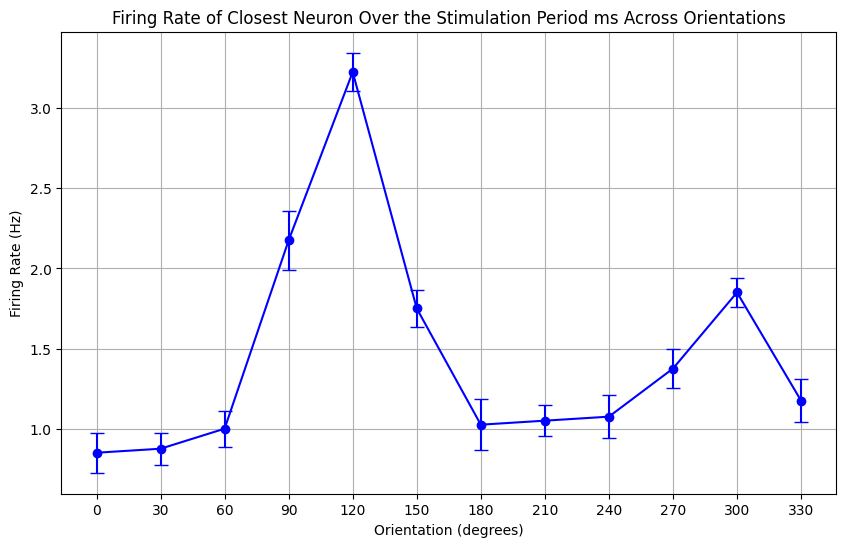

In [43]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
selected_id = select_neuron_with_median(filtered_df, 'OSI')
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  12359 OSI =  0.2322728269493264 
DSI =  0.1190191964720364 defined tuning angle = 213.536187368 
type =  LIFe5Rbp4

median neuron in DSI  :
id =  190292 OSI =  0.2507642669928249 
DSI =  0.1191947352740949 
defined tuning angle = 29.9566787004 
type =  LIFe6Ntsr1
190292


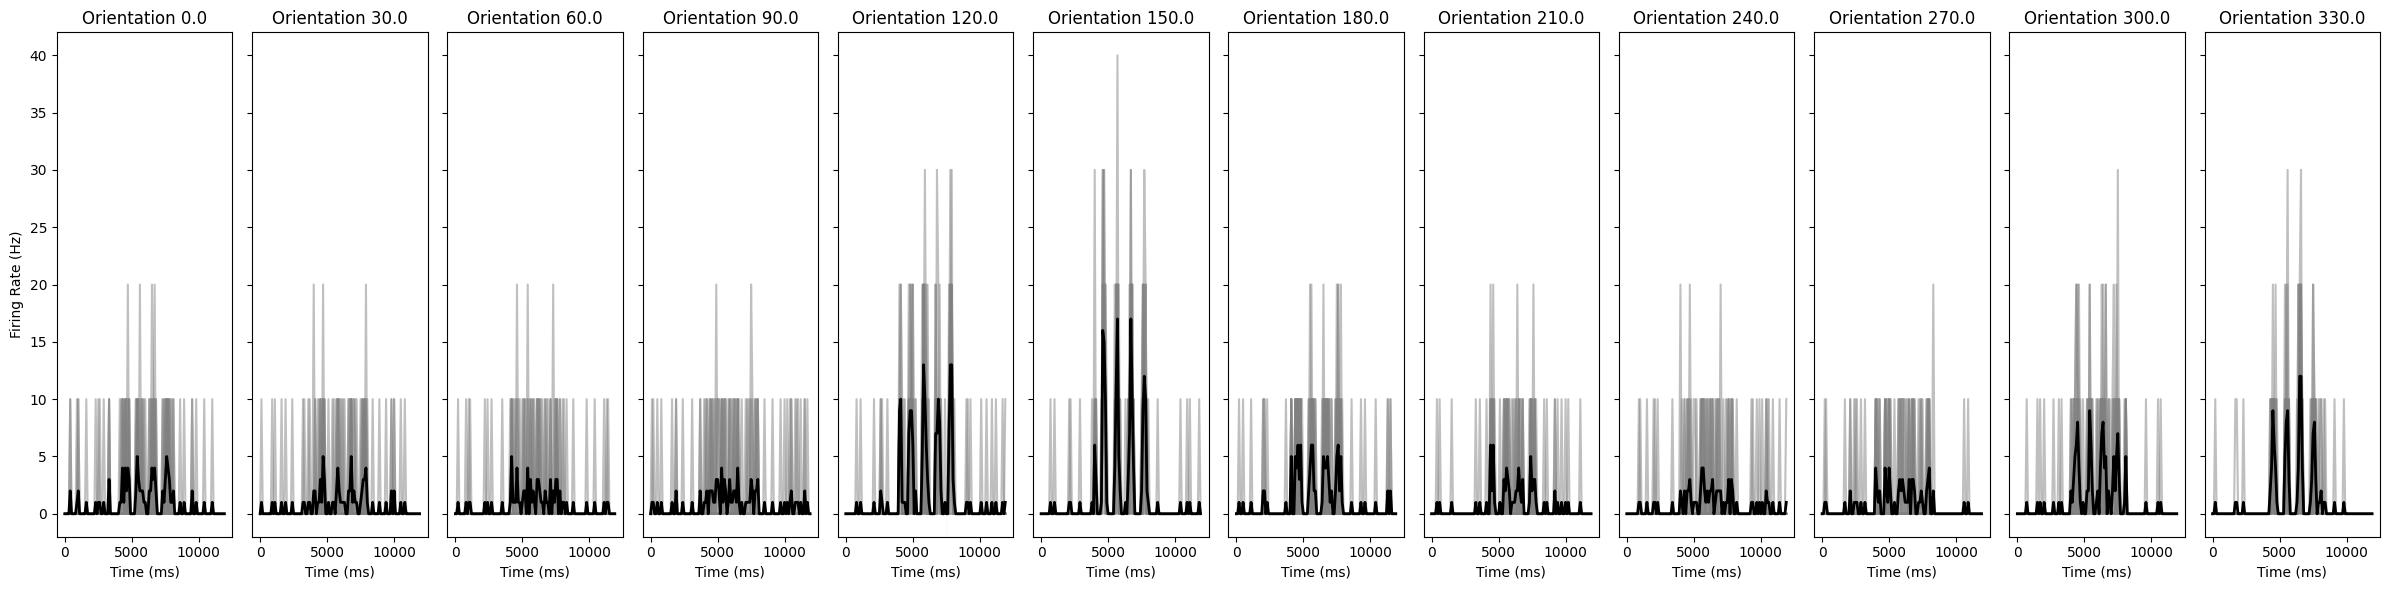

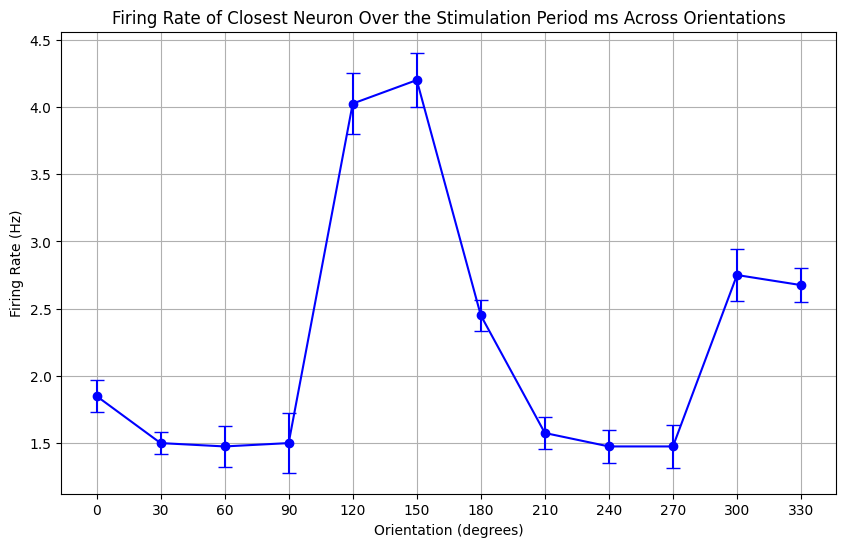

In [35]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
selected_id = select_neuron_with_median(filtered_df, 'DSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  22715 OSI =  0.3176057794518321 
DSI =  0.1701887945752703 defined tuning angle = 112.552412646 
type =  e5Rbp4

median neuron in OSI  :
id =  20837 OSI =  0.3364657112128329 
DSI =  0.1976877176217138 
defined tuning angle = 0.0599001663894 
type =  e5Rbp4
20837


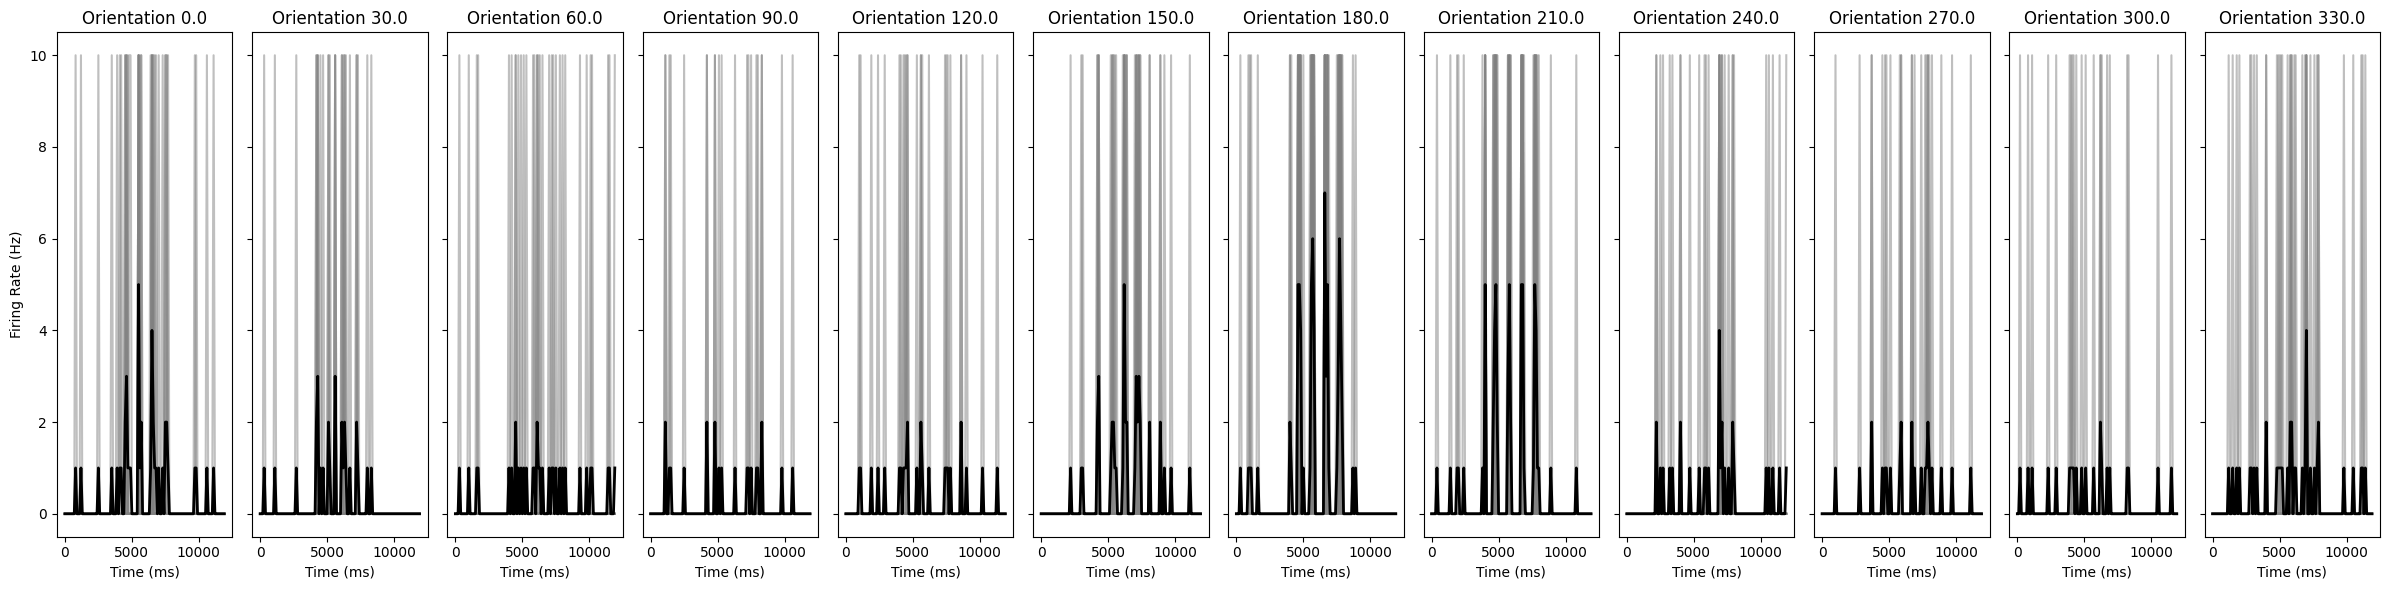

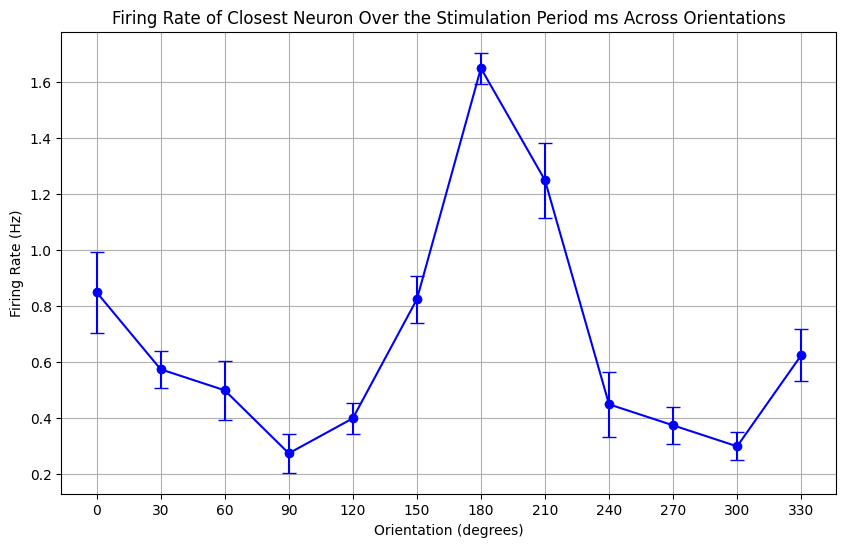

In [38]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e5Rbp4')
selected_id = select_neuron_with_median(filtered_df, 'OSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  25752 OSI =  0.3337590851326541 
DSI =  0.1456061345593152 defined tuning angle = 294.46921797 
type =  e5Rbp4

median neuron in DSI  :
id =  23340 OSI =  0.1852971522735516 
DSI =  0.145679104539062 
defined tuning angle = 149.990016639 
type =  e5Rbp4
23340


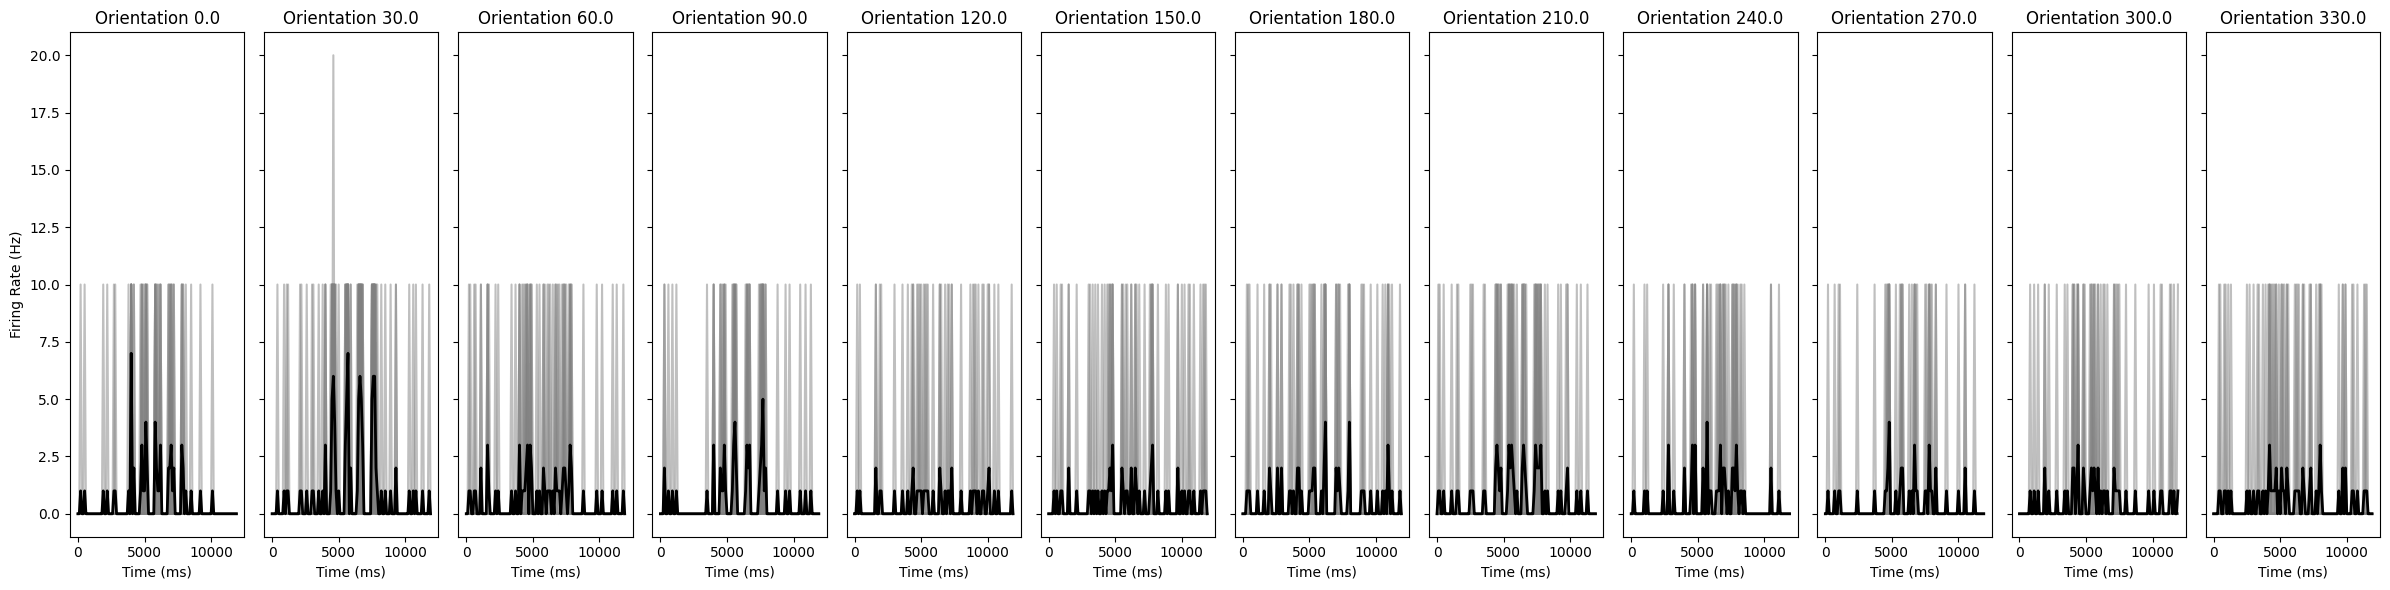

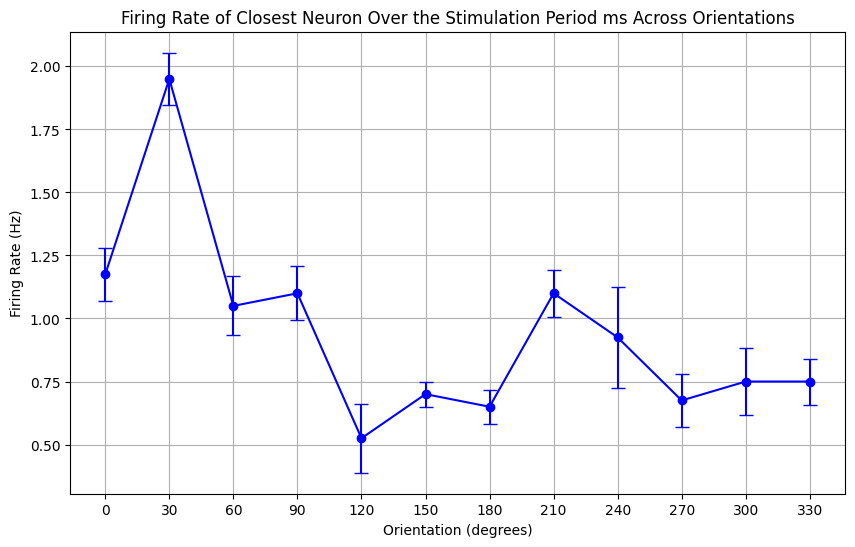

In [39]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e5Rbp4')
selected_id = select_neuron_with_median(filtered_df, 'DSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  78592 OSI =  0.3037815045782964 
DSI =  0.1542155774040139 defined tuning angle = 237.692489558 
type =  e23Cux2

median neuron in OSI  :
id =  72328 OSI =  0.3031192344921906 
DSI =  0.0628697292582648 
defined tuning angle = 59.976357475 
type =  e23Cux2
72328


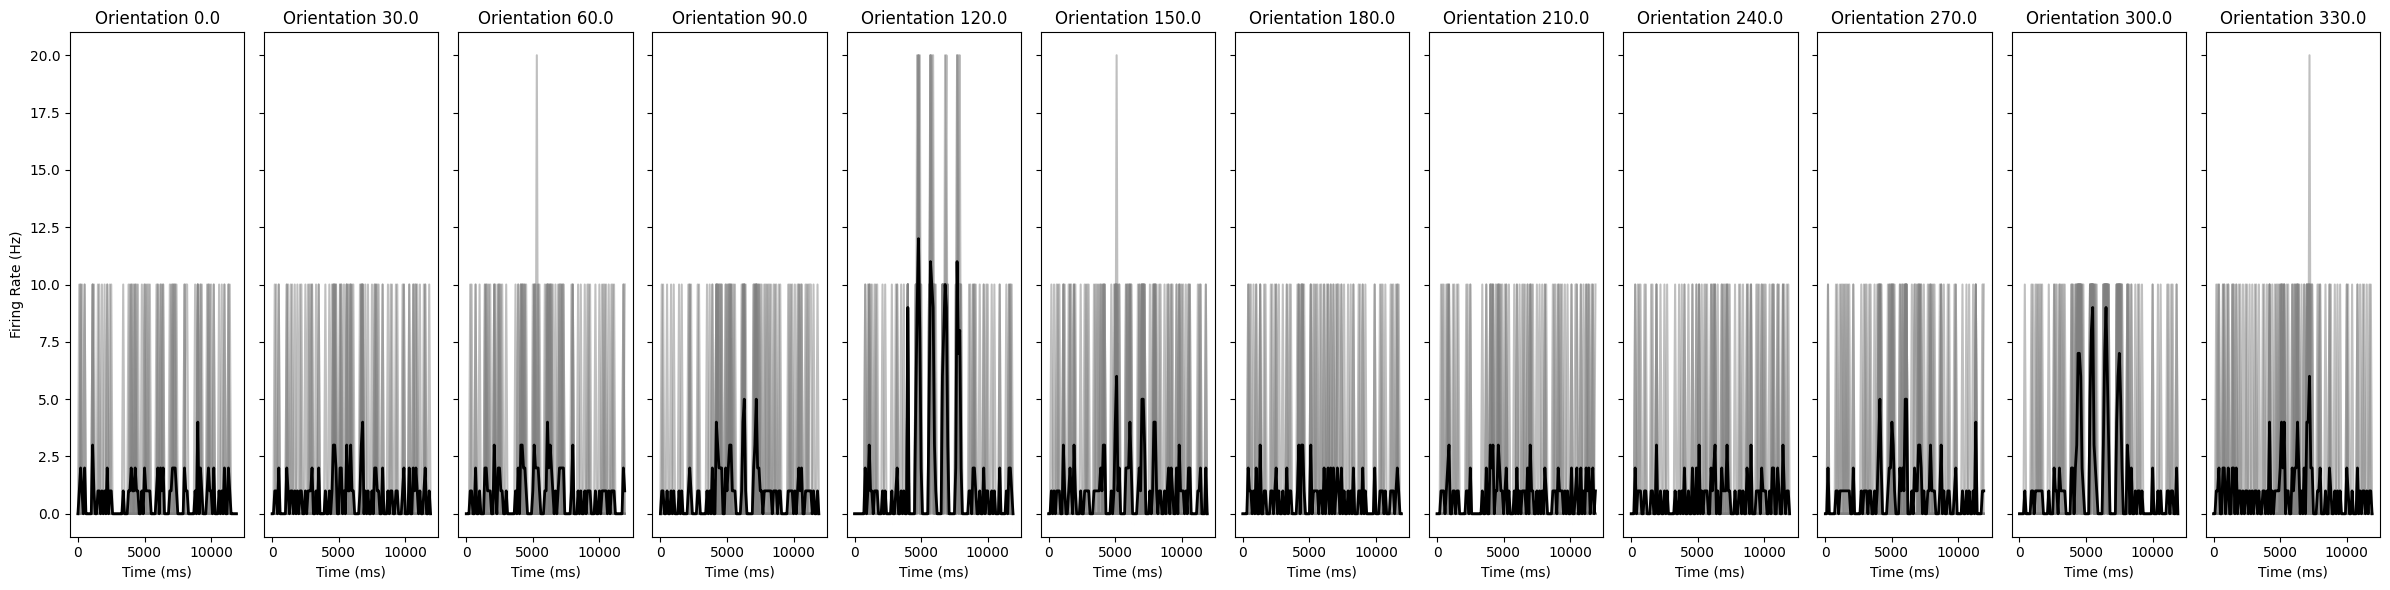

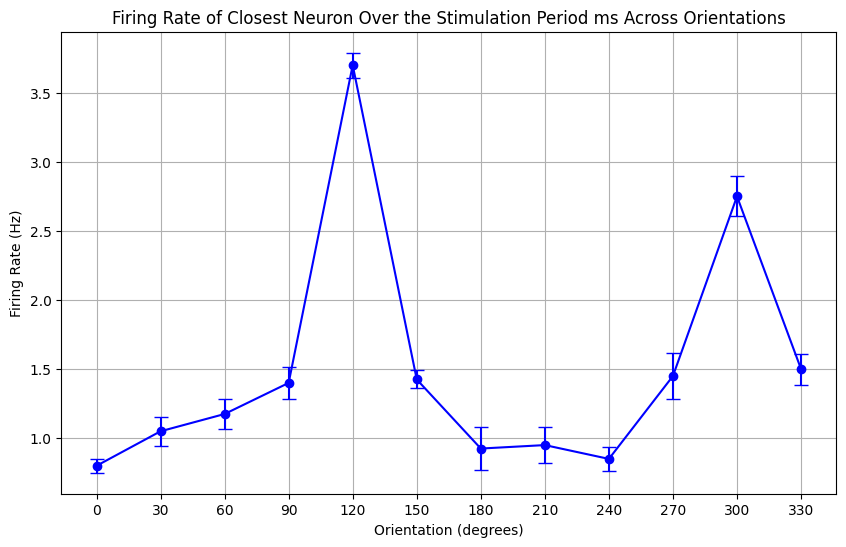

In [40]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'OSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175118

real median neuron:
id =  75232 OSI =  0.2532040270407658 
DSI =  0.1194547290285049 defined tuning angle = 142.365828671 
type =  e23Cux2

median neuron in DSI  :
id =  81844 OSI =  0.2893284249775676 
DSI =  0.1218021698364729 
defined tuning angle = 329.955079202 
type =  e23Cux2
81844


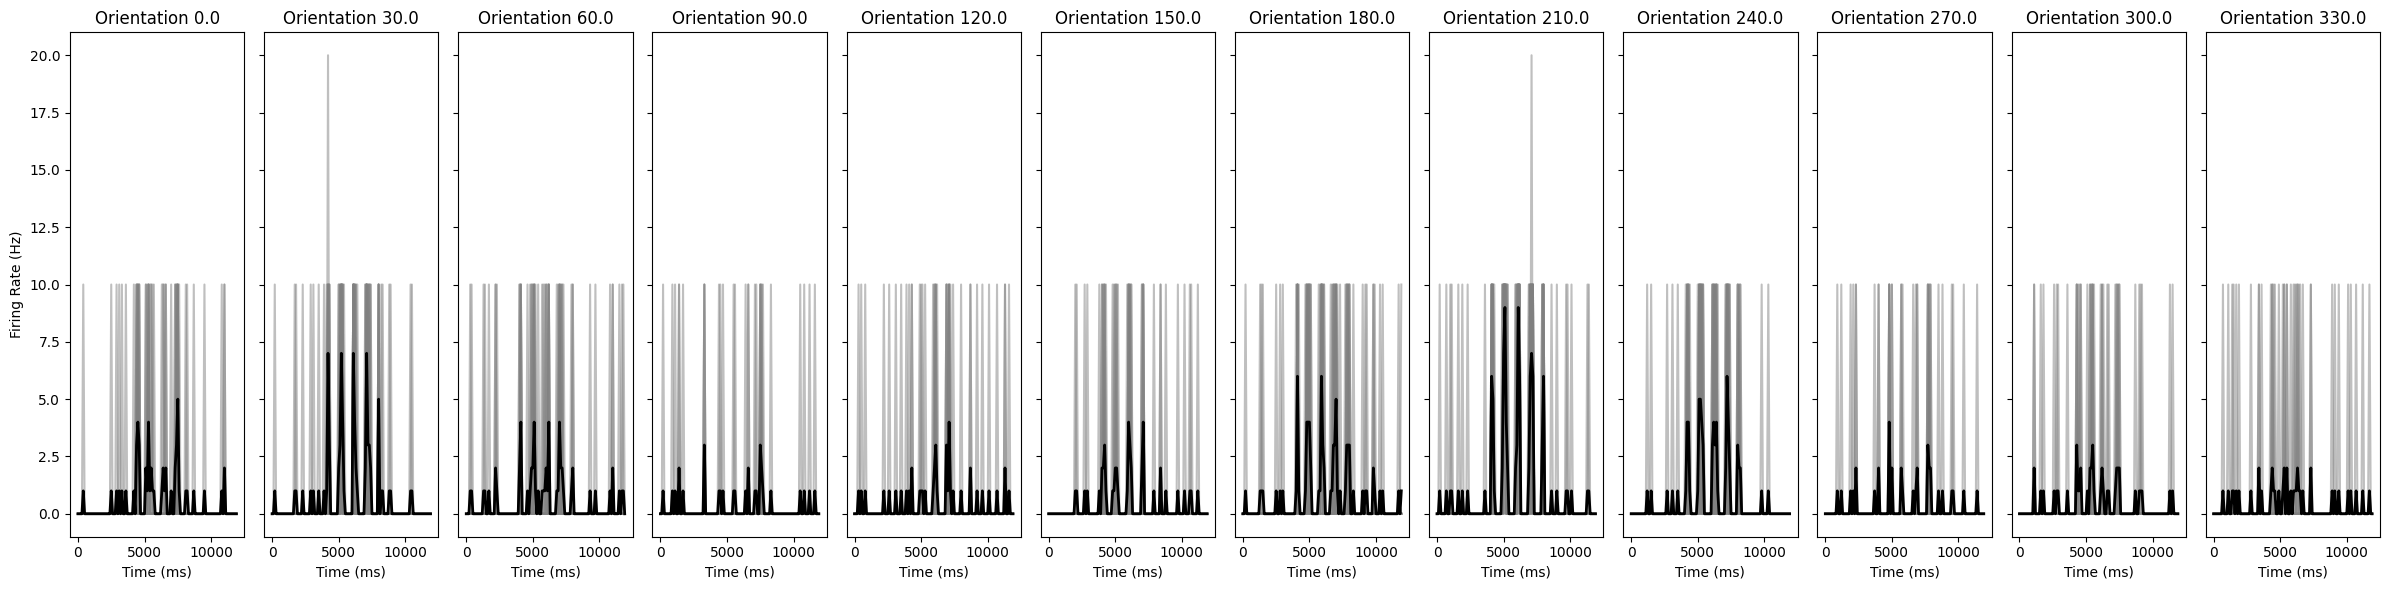

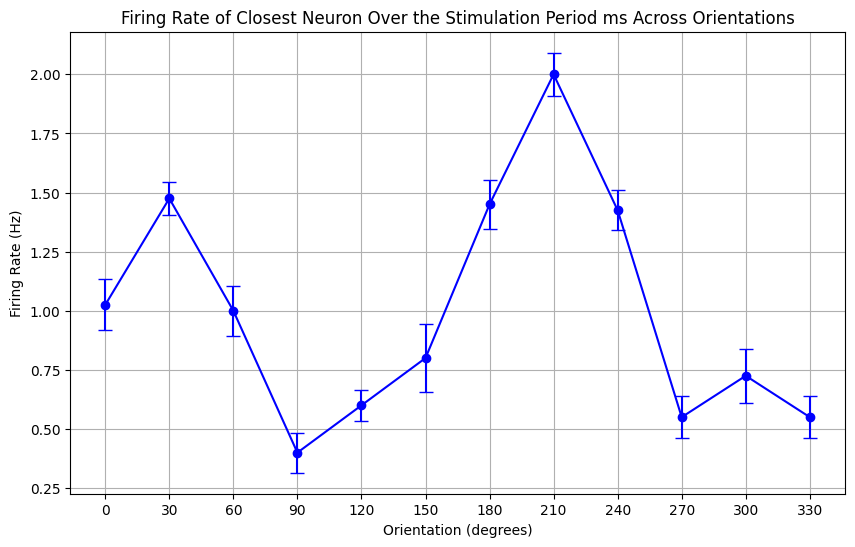

In [41]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'DSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175114

real median neuron:
id =  73799 OSI =  0.394822816245938 
DSI =  0.046445355556818 defined tuning angle = 101.710142643 
type =  e23Cux2

median neuron in OSI  :
id =  74442 OSI =  0.3911281085614853 
DSI =  0.1775232190343082 
defined tuning angle = 119.95271495 
type =  e23Cux2
74442


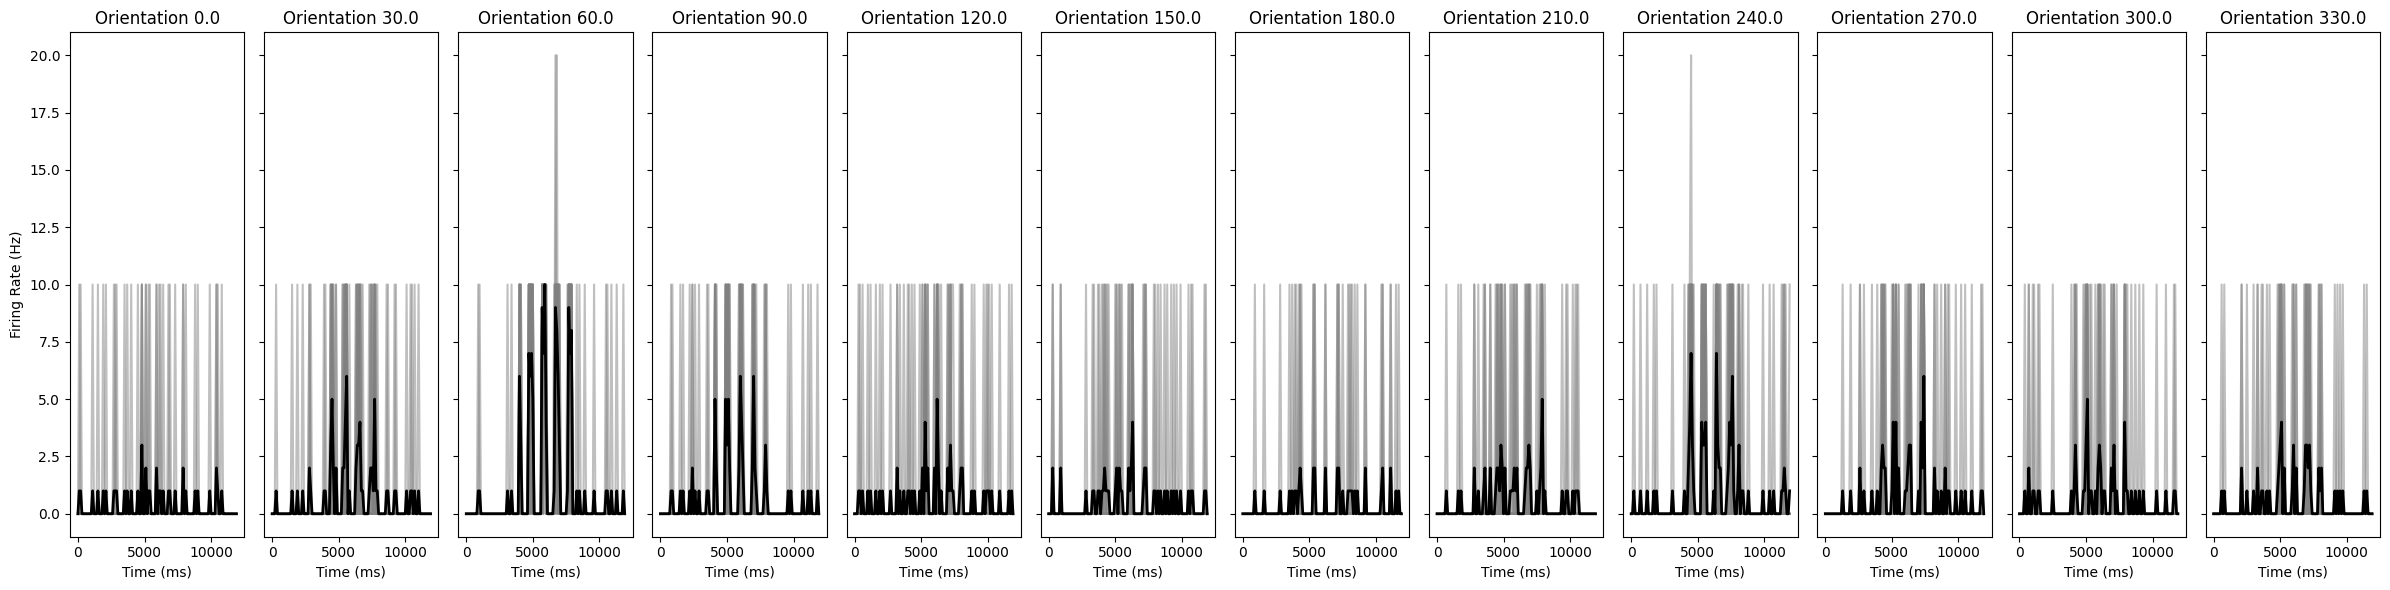

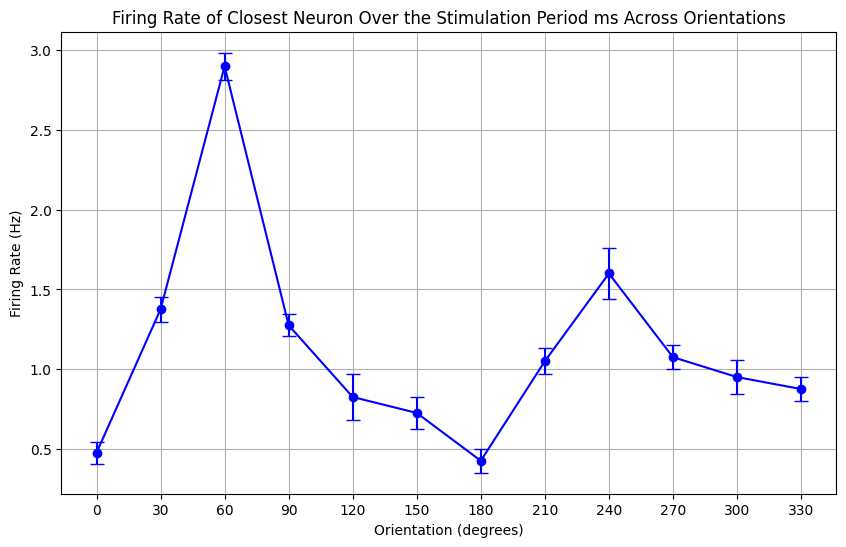

In [20]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_AboveBaseline_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'OSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  175114

real median neuron:
id =  70408 OSI =  0.5389808457588868 
DSI =  0.1556557125944975 defined tuning angle = 5.50397982505 
type =  e23Cux2

median neuron in DSI  :
id =  76556 OSI =  0.4621849776990393 
DSI =  0.1524269388056703 
defined tuning angle = 179.929072425 
type =  e23Cux2
76556


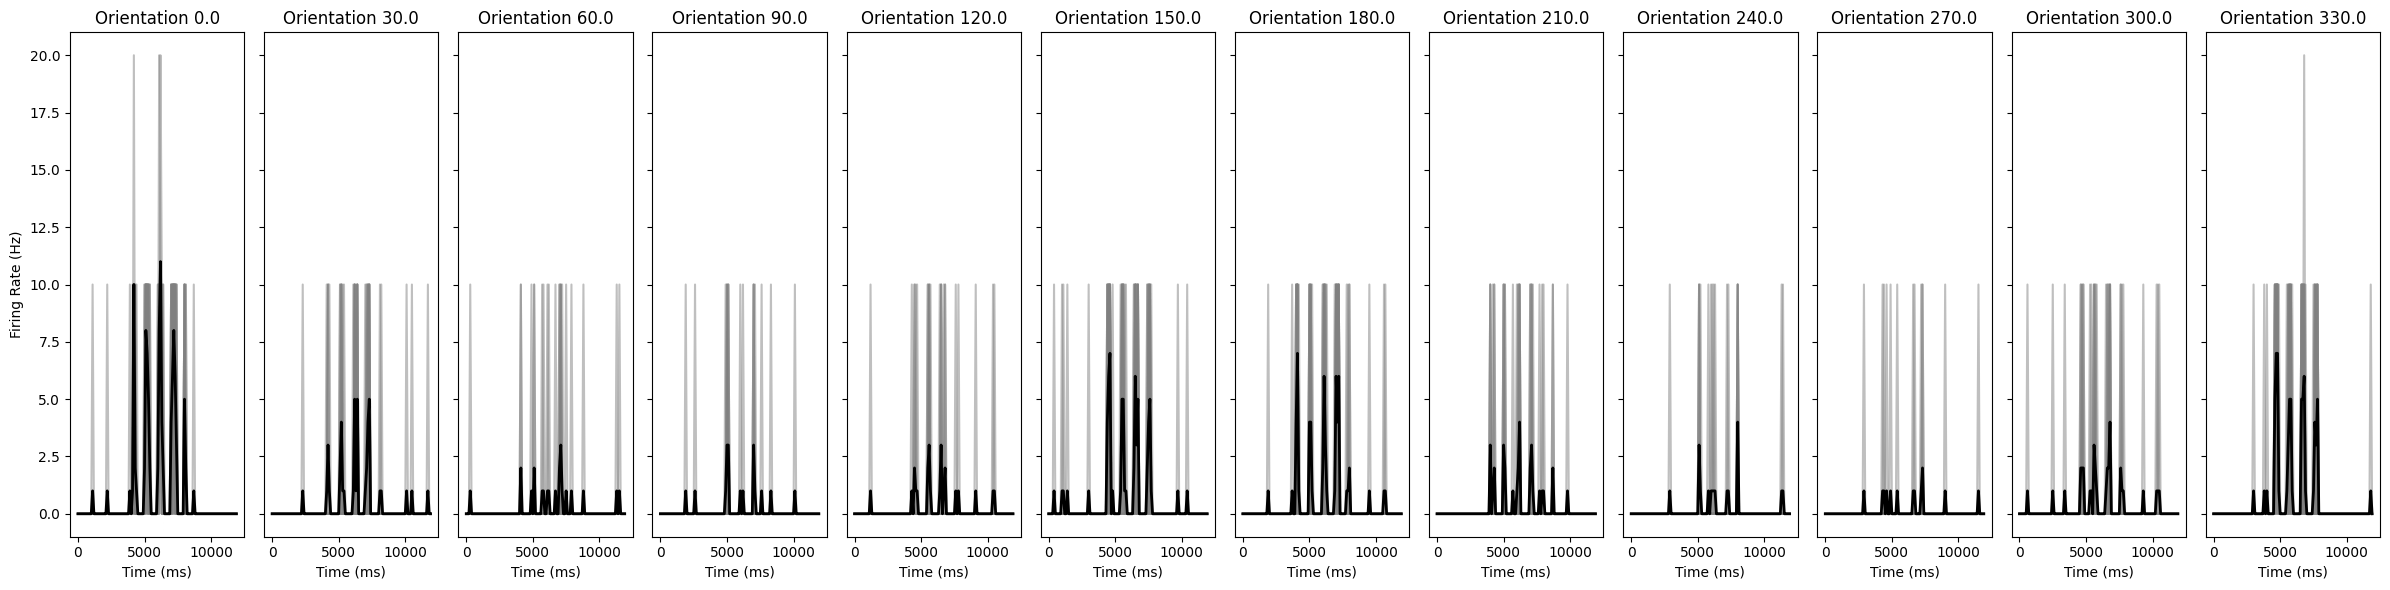

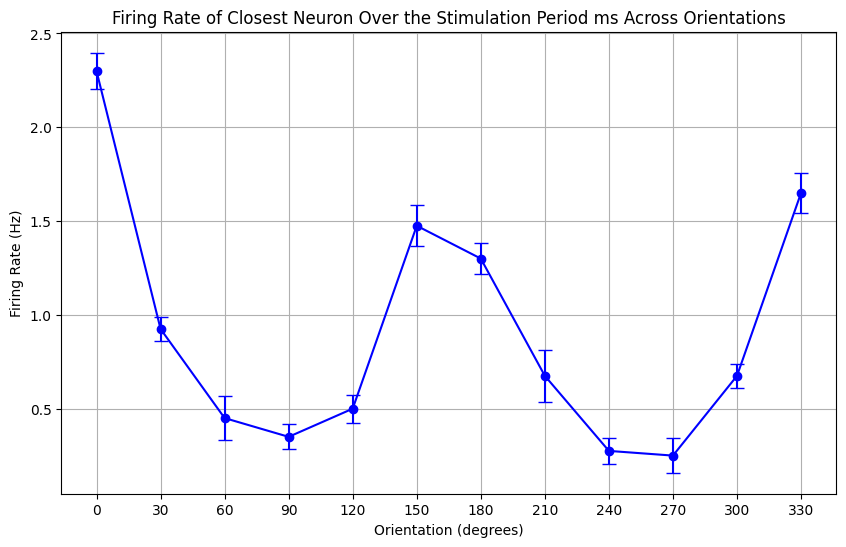

In [21]:
filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_AboveBaseline_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'DSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  167923

real median neuron:
id =  78457 OSI =  0.7000000000000001 
DSI =  0.4219004621945799 defined tuning angle = 233.862400504 
type =  e23Cux2

median neuron in OSI  :
id =  75500 OSI =  0.7044680414095429 
DSI =  0.3620710871845842 
defined tuning angle = 149.969264717 
type =  e23Cux2
75500


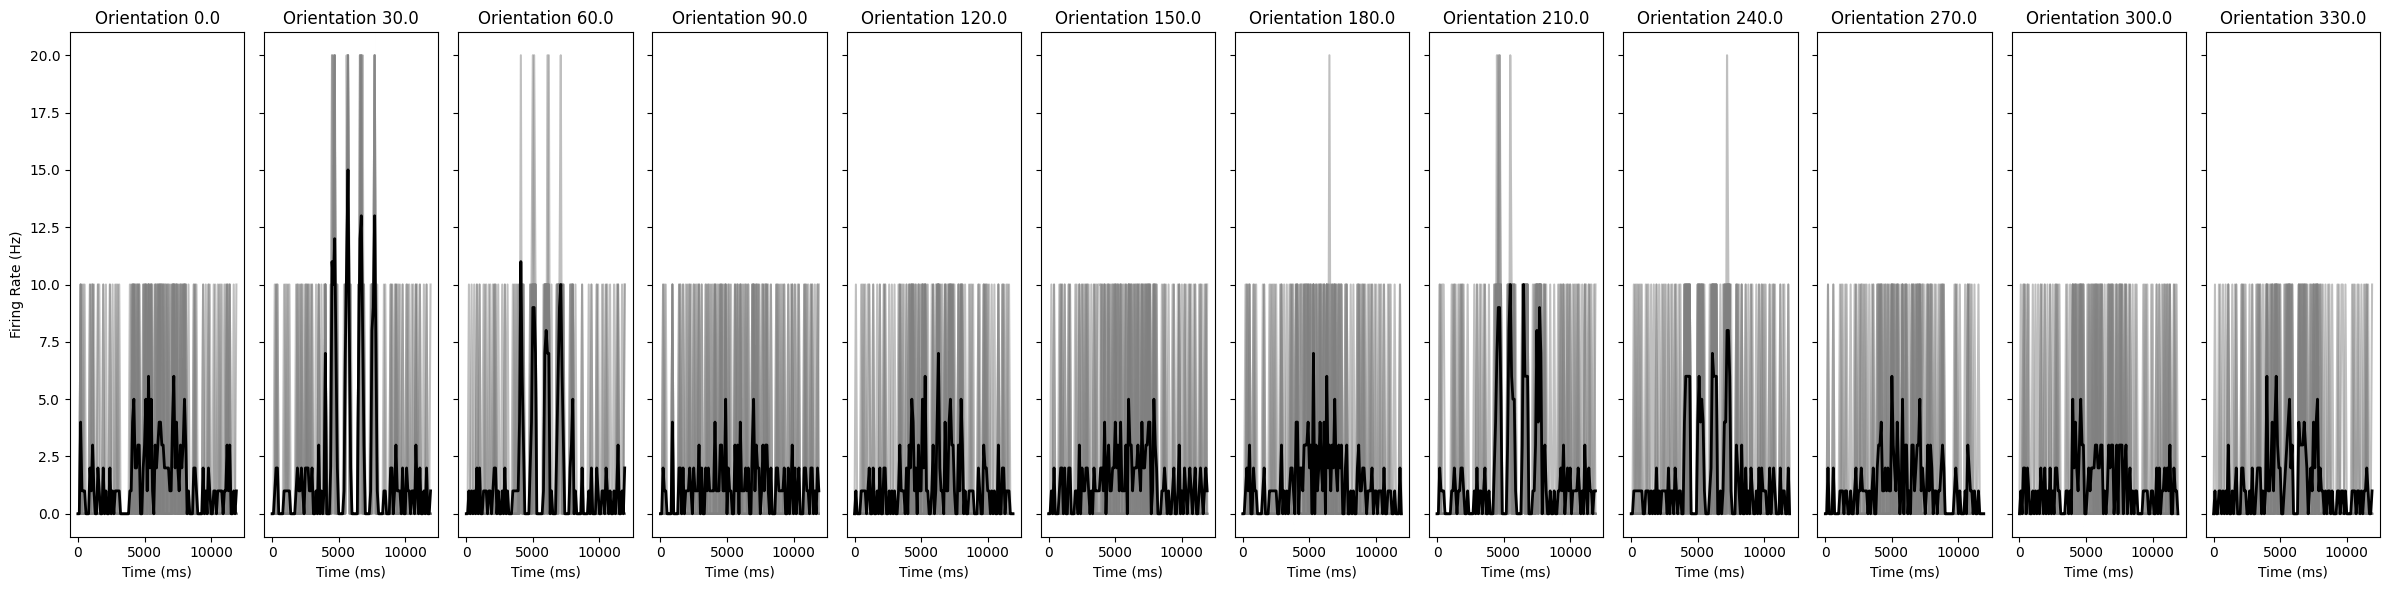

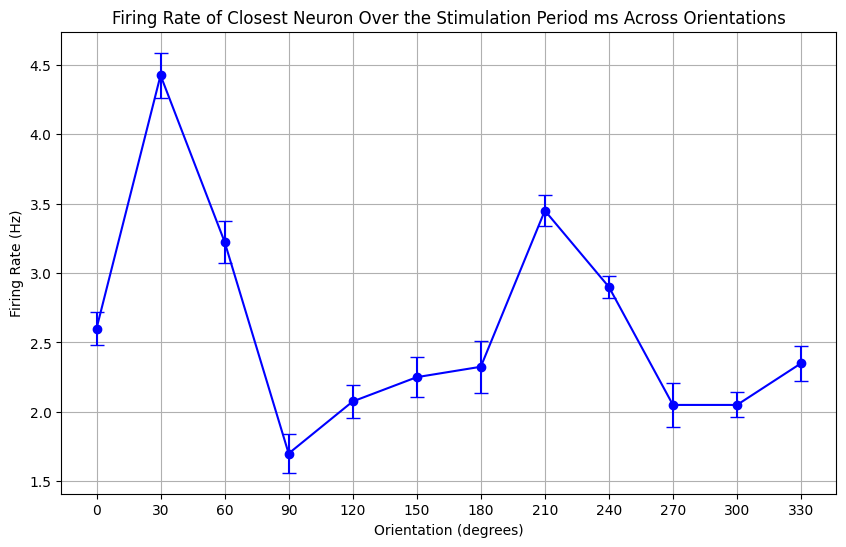

In [18]:
filtered_df = read_and_filter('v1_nodes.csv', 'syngap simulation 1/OSI_DSI_AboveBaseline_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'OSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

number of excitatory neurons :  192578

number of firing excitatory neurons:  167923

real median neuron:
id =  74580 OSI =  0.7650229942769011 
DSI =  0.4259813619176579 defined tuning angle = 123.867917094 
type =  e23Cux2

median neuron in DSI  :
id =  71271 OSI =  0.638779020578312 
DSI =  0.42315253257566 
defined tuning angle = 29.9881787375 
type =  e23Cux2
71271


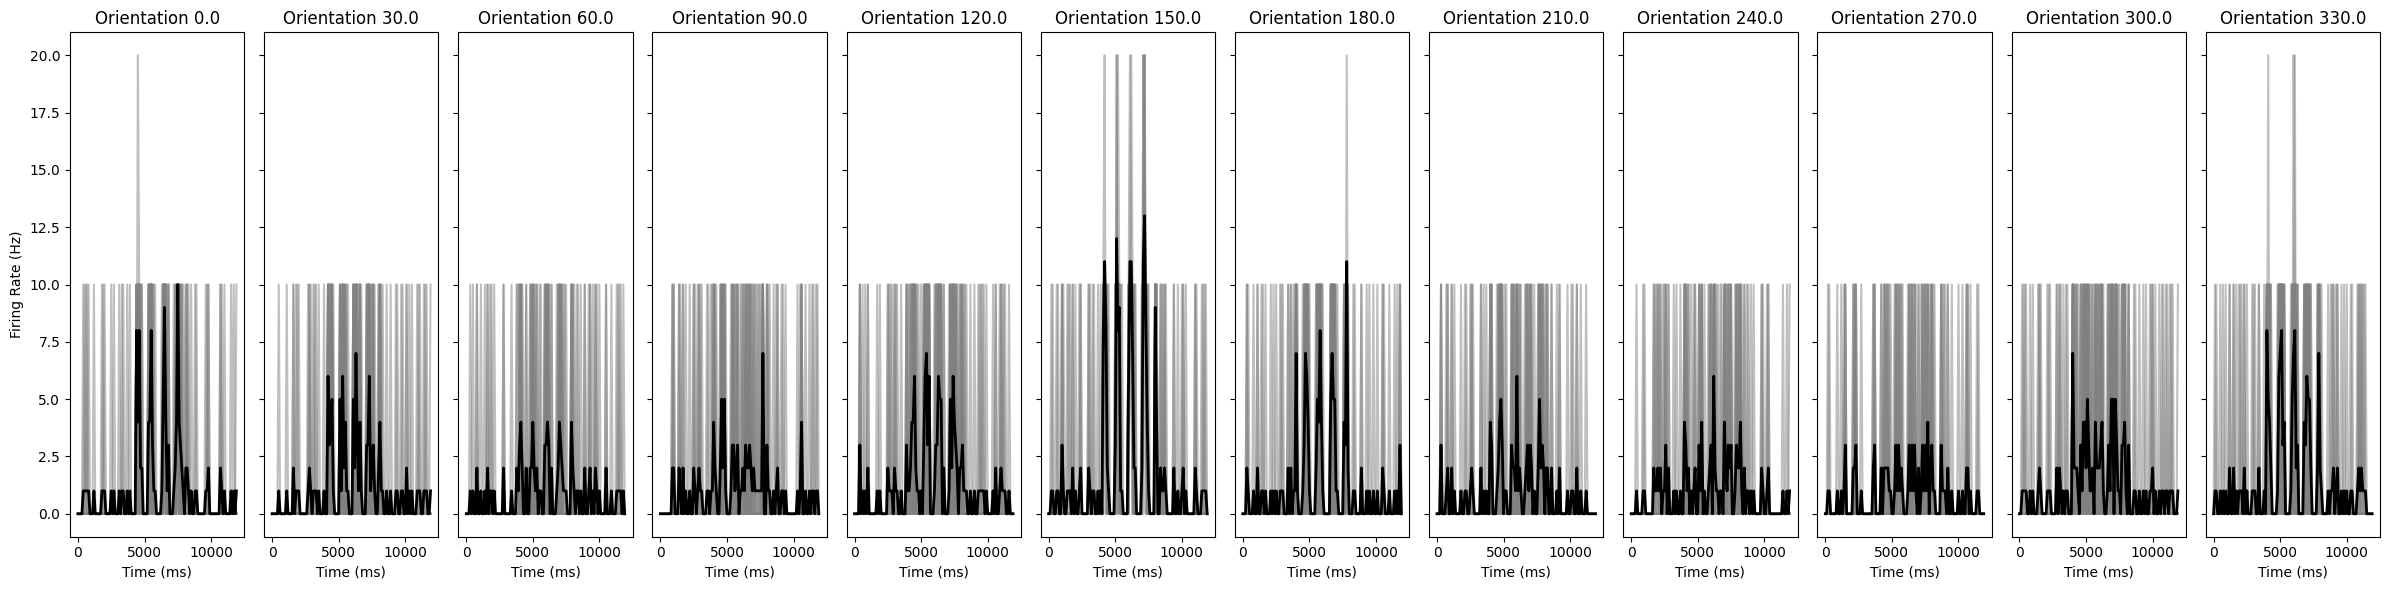

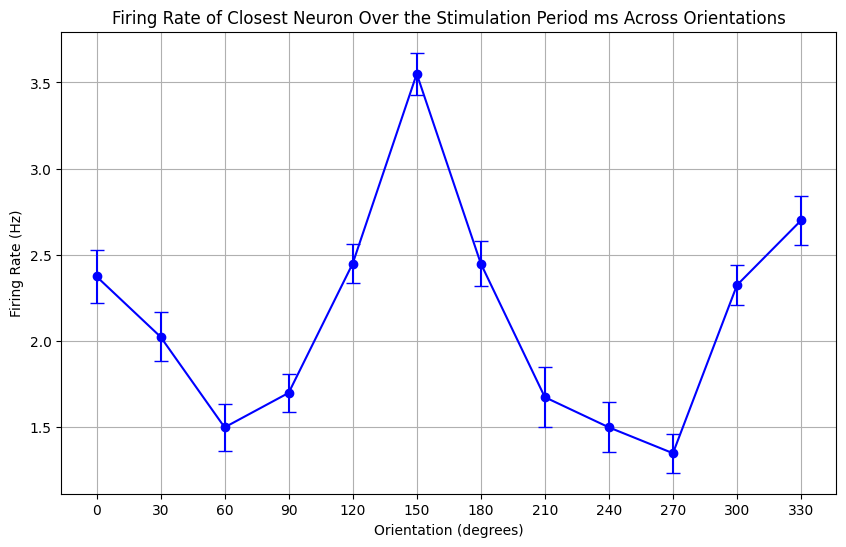

In [19]:
filtered_df = read_and_filter('v1_nodes.csv', 'syngap simulation 1/OSI_DSI_AboveBaseline_DF.csv')
filtered_df = filter_by_pop_name(filtered_df, 'e23Cux2')
selected_id = select_neuron_with_median(filtered_df, 'DSI')
print(selected_id)
plot_firing_rates_and_tuning_curve(selected_id)

# 2: Compare tuning curves in two populations
## 2.1: Plot the behavior of a selected neuron in two conditions

In [2]:
def plot_firing_rates_and_return_mean_and_SEM(filenames, selected_id):
    # Get the list of .txt files
    txt_files = sorted(glob.glob(filenames))
    
    # Create a dictionary to store the spikes of the closest neuron for each file
    neuron_spikes = {file: [] for file in txt_files}
    
    for file in txt_files:
        data = pd.read_csv(file, sep=' ', header=None, names=['time', 'neuron_id'])
        neuron_spikes[file] = data[data['neuron_id'] == selected_id]['time'].tolist()
    
    # Calculate the firing rate in each 100-ms bin
    bin_size = 100  # ms
    num_bins = 12000 // bin_size
    
    # Create a dictionary to store firing rates
    firing_rates = {file: np.zeros(num_bins) for file in txt_files}
    
    for file, spikes in neuron_spikes.items():
        for spike in spikes:
            bin_index = int(spike // bin_size)
            if bin_index < num_bins:
                firing_rates[file][bin_index] += 1
        
        # Convert spike counts to firing rates (Hz)
        firing_rates[file] /= (bin_size / 1000)
    
    # Plot 8 graphs with 10 grey traces and 1 black bold average trace on the same row
    orientations = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]
    
    # Set up the plot
    fig, axes = plt.subplots(1, len(orientations), figsize=(24, 6), sharey=True)
    
    for idx, ori in enumerate(orientations):
        ax = axes[idx]
        
        # Extract the relevant files for this orientation
        ori_files = [file for file in txt_files if f'ori{int(ori)}.0' in file]
        
        all_traces = []
        
        for file in ori_files:
            trace = firing_rates[file]
            all_traces.append(trace)
            ax.plot(np.arange(num_bins) * bin_size, trace, color='grey', alpha=0.5)
        
        # Calculate and plot the average trace
        avg_trace = np.mean(all_traces, axis=0)
        ax.plot(np.arange(num_bins) * bin_size, avg_trace, color='black', linewidth=2)
        
        ax.set_title(f'Orientation {int(ori)}.0')
        ax.set_xlabel('Time (ms)')
        if idx == 0:
            ax.set_ylabel('Firing Rate (Hz)')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Calculate the firing rates for the closest_neuron over the last 2500 ms for each orientation
    firing_rates_middle_4000ms = {ori: [] for ori in orientations}
    
    for ori in orientations:
        # Extract the relevant files for this orientation
        ori_files = [file for file in txt_files if f'ori{int(ori)}.0' in file]
        
        for file in ori_files:
            spikes = neuron_spikes[file]
            # Filter spikes that occur in the last 2500 ms (after 500 ms)
            middle_4000ms_spikes = [spike for spike in spikes if (spike >= 4000.0 and spike <= 8000.0)]
            firing_rate = len(middle_4000ms_spikes) / 4.0  # Firing rate in Hz
            firing_rates_middle_4000ms[ori].append(firing_rate)
    
    # Calculate the mean firing rate and SEM for each orientation
    mean_firing_rates = [np.mean(firing_rates_middle_4000ms[ori]) for ori in orientations]
    sem_firing_rates = [stats.sem(firing_rates_middle_4000ms[ori]) for ori in orientations]

    return mean_firing_rates, sem_firing_rates



In [3]:
def print_neuron_properties(filtered_df, id):
    neuron = filtered_df[filtered_df['id'] == id]
    print('\nneuron properties:\nid = ', neuron['id'], 'OSI = ', neuron['OSI'], '\nDSI = ', neuron['DSI'], 'defined tuning angle =', neuron['tuning_angle'], '\ntype = ', neuron['pop_name'])

number of excitatory neurons :  192578

number of firing excitatory neurons:  167923

real median neuron:
id =  78457 OSI =  0.7000000000000001 
DSI =  0.4219004621945799 defined tuning angle = 233.862400504 
type =  e23Cux2

median neuron in OSI  :
id =  75500 OSI =  0.7044680414095429 
DSI =  0.3620710871845842 
defined tuning angle = 149.969264717 
type =  e23Cux2

neuron properties:
id =  75500    75500
Name: id, dtype: int64 OSI =  75500    0.704468
Name: OSI, dtype: float64 
DSI =  75500    0.362071
Name: DSI, dtype: float64 defined tuning angle = 75500    149.969265
Name: tuning_angle, dtype: float64 
type =  75500    e23Cux2
Name: pop_name, dtype: object


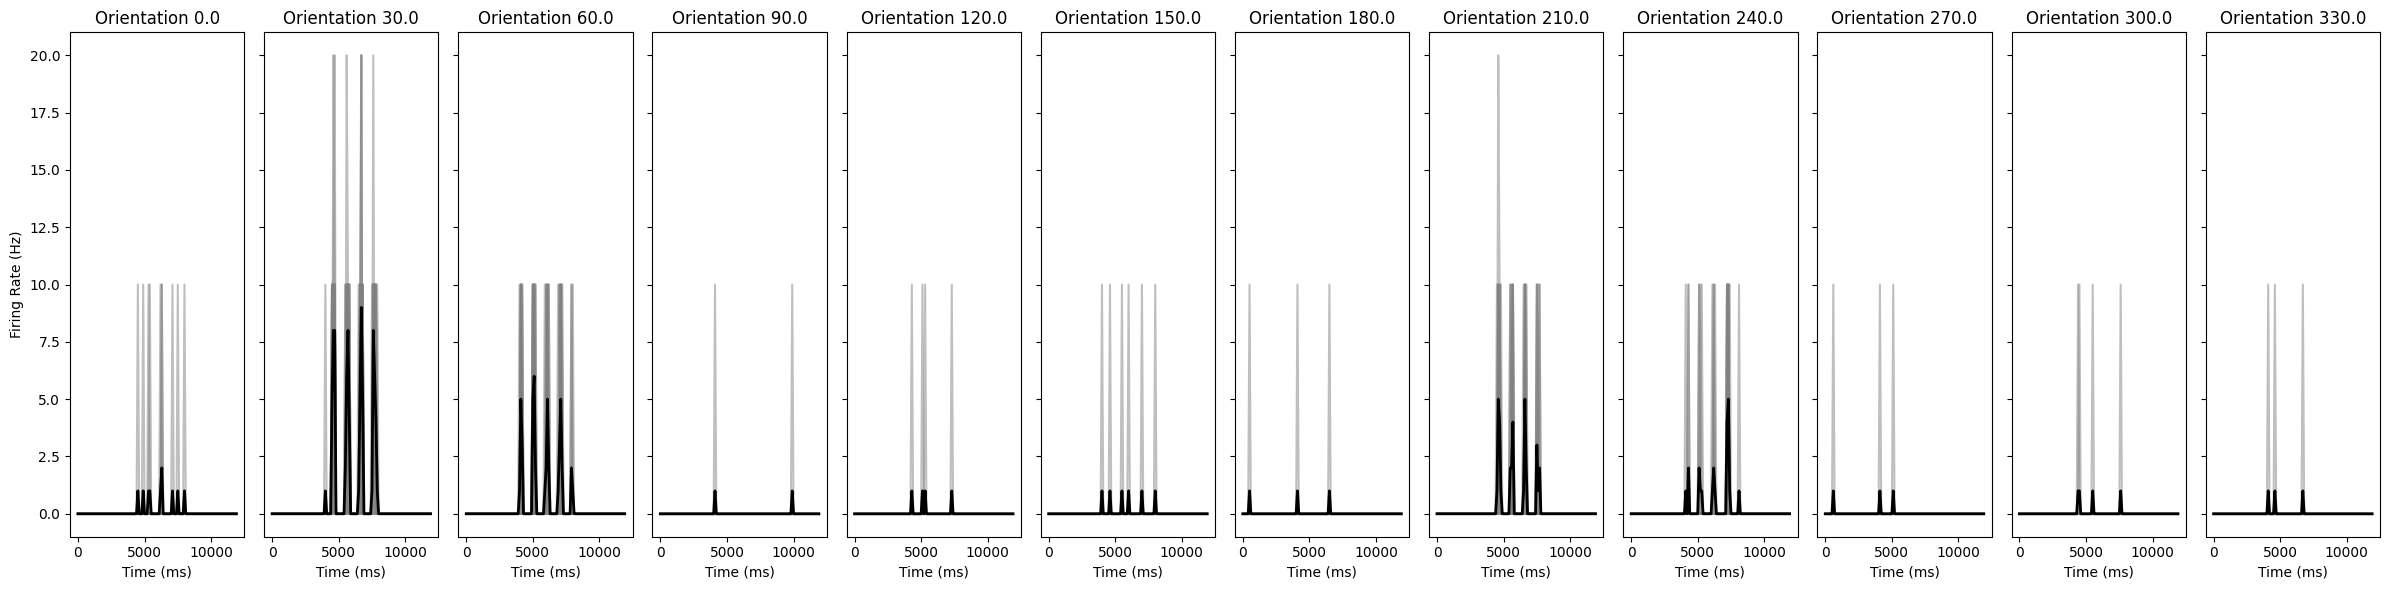

number of excitatory neurons :  192578

number of firing excitatory neurons:  175114

real median neuron:
id =  73799 OSI =  0.394822816245938 
DSI =  0.046445355556818 defined tuning angle = 101.710142643 
type =  e23Cux2

median neuron in OSI  :
id =  74442 OSI =  0.3911281085614853 
DSI =  0.1775232190343082 
defined tuning angle = 119.95271495 
type =  e23Cux2

neuron properties:
id =  75500    75500
Name: id, dtype: int64 OSI =  75500    0.238569
Name: OSI, dtype: float64 
DSI =  75500    0.074597
Name: DSI, dtype: float64 defined tuning angle = 75500    149.969265
Name: tuning_angle, dtype: float64 
type =  75500    e23Cux2
Name: pop_name, dtype: object


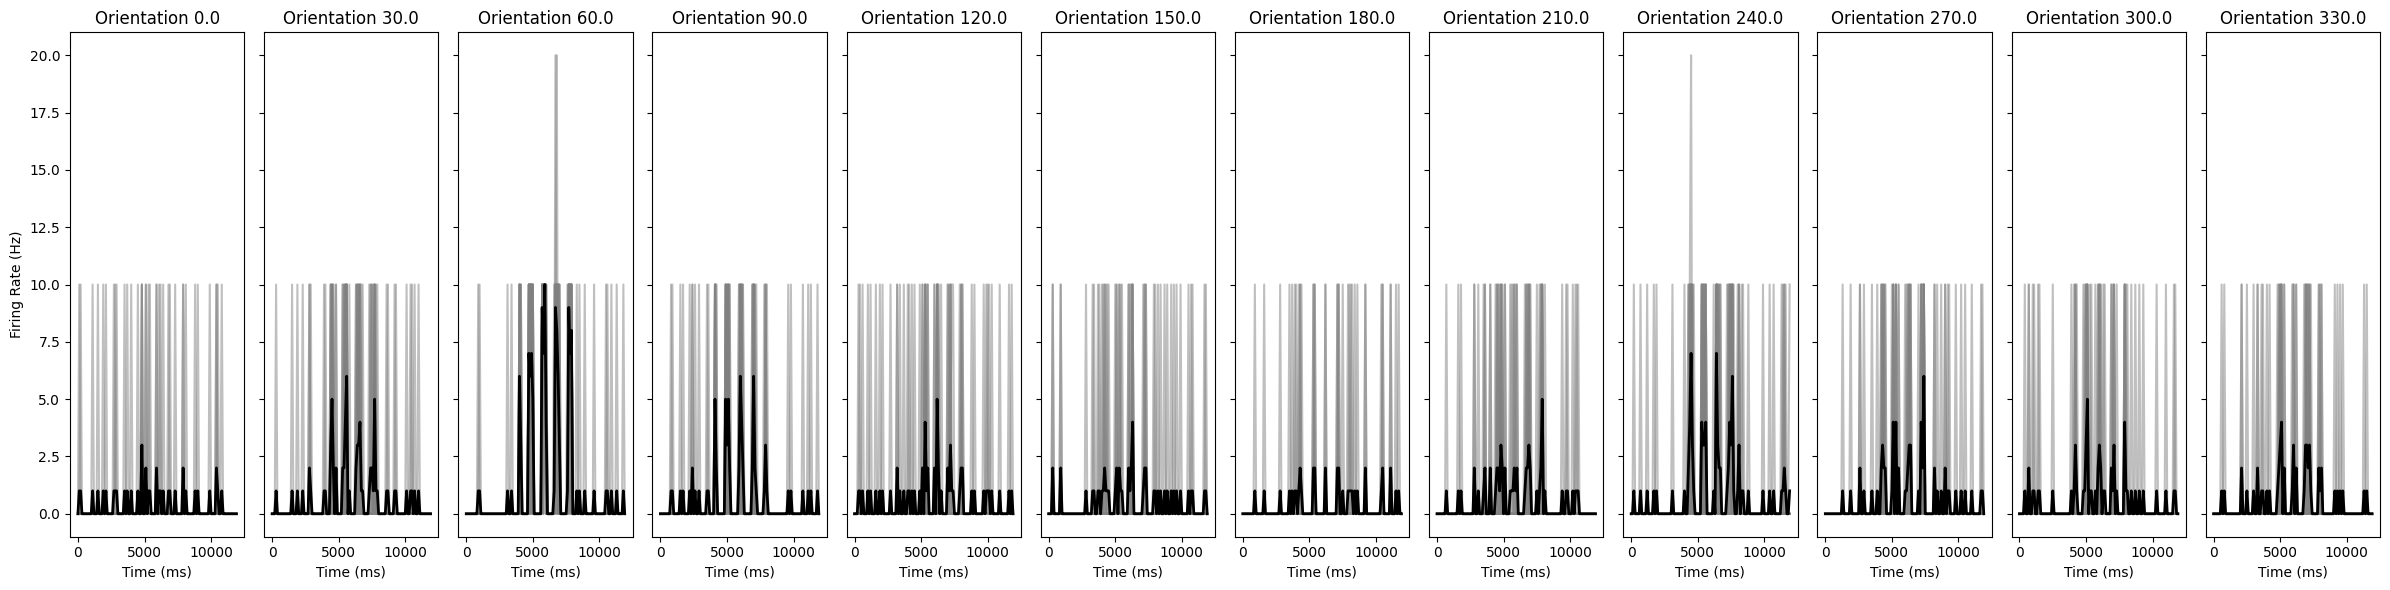

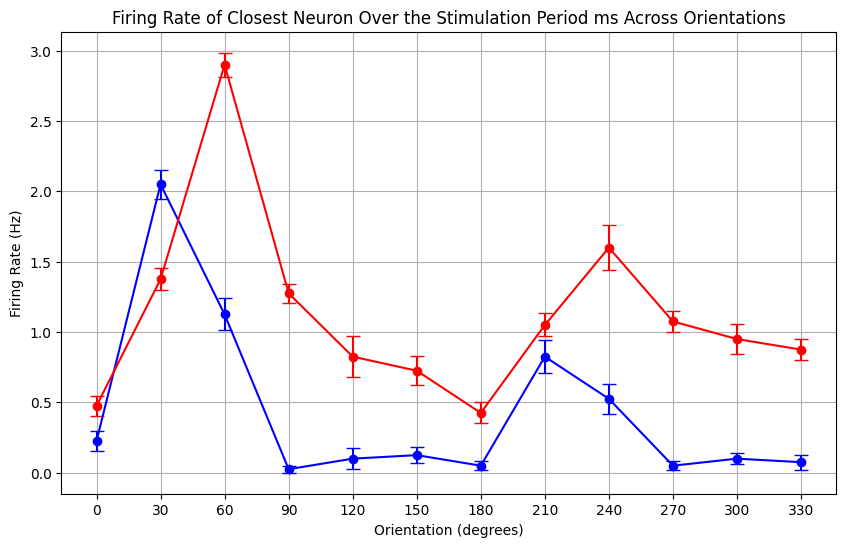

In [39]:
sg_filtered_df = read_and_filter('v1_nodes.csv', 'syngap simulation 1/OSI_DSI_AboveBaseline_DF.csv')
sg_filtered_df = filter_by_pop_name(sg_filtered_df, 'e23Cux2')
sg_selected_id = select_neuron_with_median(sg_filtered_df, 'OSI')
print_neuron_properties(sg_filtered_df, sg_selected_id)
sg_mean_firing_rates, sg_sem_firing_rates = plot_firing_rates_and_return_mean_and_SEM('syngap simulation 1/12s_SF0.04_TF2.0_ori*.txt', sg_selected_id)

ct_filtered_df = read_and_filter('v1_nodes.csv', 'simulation 2/OSI_DSI_AboveBaseline_DF.csv')
ct_filtered_df = filter_by_pop_name(ct_filtered_df, 'e23Cux2')
ct_selected_id = select_neuron_with_median(ct_filtered_df, 'OSI')
print_neuron_properties(ct_filtered_df, sg_selected_id)
ct_mean_firing_rates, ct_sem_firing_rates = plot_firing_rates_and_return_mean_and_SEM('simulation 2/12s_SF0.04_TF2.0_ori*.txt', ct_selected_id)

# Plot the tuning curve
orientations = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0, 180.0, 210.0, 240.0, 270.0, 300.0, 330.0]
plt.figure(figsize=(10, 6))
plt.errorbar(orientations, sg_mean_firing_rates, yerr=sg_sem_firing_rates, marker='o', linestyle='-', color='b', capsize=5)
plt.errorbar(orientations, ct_mean_firing_rates, yerr=ct_sem_firing_rates, marker='o', linestyle='-', color='r', capsize=5)

plt.title('Firing Rate of Closest Neuron Over the Stimulation Period ms Across Orientations')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Firing Rate (Hz)')
plt.xticks(orientations)
plt.grid(True)

    
plt.show()

## 2.2: Plot the behavior of a population in two conditions
1. Plot the average tuning curves normalized to the highest average firing rate.
2. Plot unormalized the average tuning curves.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_normalized_tuning_curves(pop_name, ctrl_folder, exp_folder):
    # Read and filter the v1_nodes.csv
    nodes_df = pd.read_csv('v1_nodes.csv', sep=' ')
    selected_nodes = nodes_df[nodes_df['pop_name'] == pop_name]

    # Define file paths for both conditions with appropriate labels
    orientation_paths = {
        ctrl_folder + '/Rates_AboveBaseline_DF.csv': ('blue', 'Control', ctrl_folder + '/Rates_FullGray_AboveBaseline_DF.csv'),
        exp_folder + '/Rates_AboveBaseline_DF.csv': ('red', 'Syngap1+/-',  exp_folder + '/Rates_FullGray_AboveBaseline_DF.csv')
    }

    plt.figure(figsize=(12, 8))

    # Process each condition
    for file_path, (color, label, gray_file_path) in orientation_paths.items():
        # Read rates data for orientations
        rates_df = pd.read_csv(file_path, sep=' ')
        # Read rates data for blank stimuli
        gray_rates_df = pd.read_csv(gray_file_path, sep=' ')

        # Merge to filter only selected neurons using the correct ID column
        merged_df = pd.merge(selected_nodes, rates_df, left_on='id', right_on='node_id')
        gray_merged_df = pd.merge(selected_nodes, gray_rates_df, left_on='id', right_on='node_id')

        # Normalize orientations based on the maximum firing rate
        def normalize_orientations(group):
            max_ori = group['Avg_rate(Hz)'].idxmax()
            preferred_angle = group.loc[max_ori, 'DG_angle']
            group['Normalized_angle'] = (group['DG_angle'] - preferred_angle) % 360
            return group

        normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)

        # Group by normalized orientation and calculate mean and SEM of the rates
        grouped = normalized_df.groupby('Normalized_angle').agg(
            Avg_rate=('Avg_rate(Hz)', 'mean'),
            SEM_rate=('Avg_rate(Hz)', 'sem')
        ).reset_index().sort_values('Normalized_angle')

        # Normalize the firing rates to [0, 1] scale using the maximum rate from orientation response
        base_rate = 0
        max_rate = grouped['Avg_rate'].max()
        grouped['Normalized_rate'] = (grouped['Avg_rate'] - base_rate) / (max_rate - base_rate)
        grouped['Normalized_SEM'] = grouped['SEM_rate'] / (max_rate - base_rate)

        # Normalize gray stimuli data
        gray_rate = gray_merged_df['Avg_rate(Hz)'].mean()
        gray_normalized_rate = (gray_rate - base_rate) / (max_rate - base_rate)
        gray_normalized_sem = gray_merged_df['Avg_rate(Hz)'].std() / np.sqrt(len(gray_merged_df['Avg_rate(Hz)'])) / (max_rate - base_rate)

        # Plot the average tuning curve
        plt.errorbar(grouped['Normalized_angle'], grouped['Normalized_rate'], yerr=grouped['Normalized_SEM'],
                     fmt='o-', color=color, capsize=5, label=label)
        
        # Plot the gray stimulus point
        plt.errorbar([360], [gray_normalized_rate], yerr=[gray_normalized_sem], fmt='o', color=color)

    plt.title(f'Tuning Curve for {pop_name}')
    plt.xlabel('Stimulus direction (Δ°, offset from preferred stimulus)')
    plt.ylabel('Normalized evoked firing rate')
    plt.xticks(list(np.arange(0, 360, 30)) + [360], labels=list(np.arange(0, 360, 30)) + ['blank'])
    plt.ylim(-0.2, 1)  # Set y-axis to span from 0 to 1
    plt.grid(True)
    plt.legend()
    plt.show()

/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


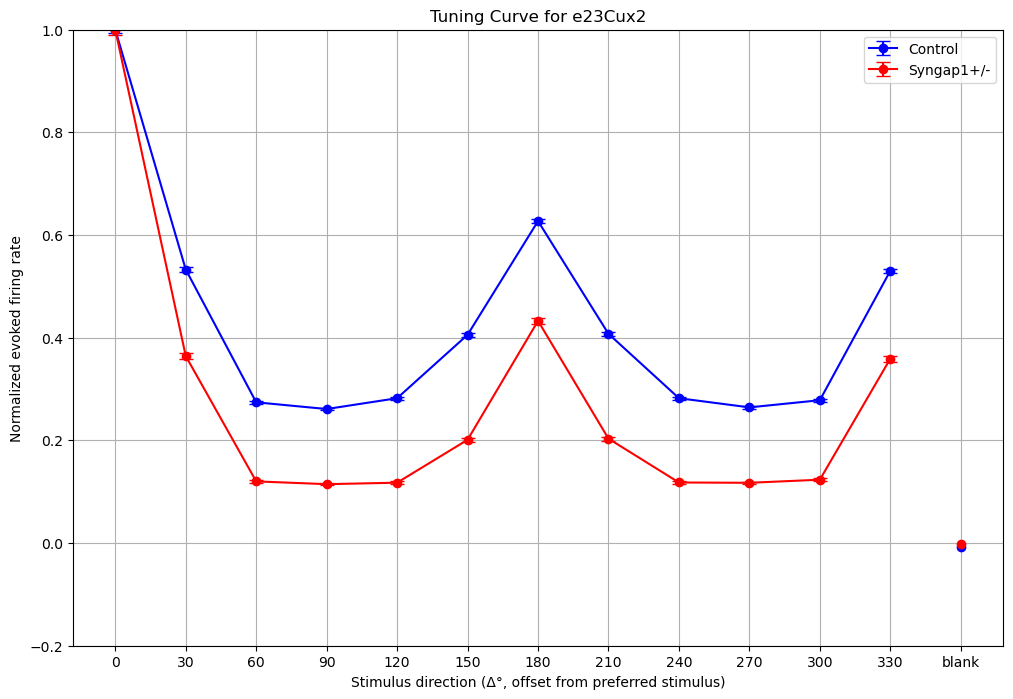

In [32]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 1')

/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


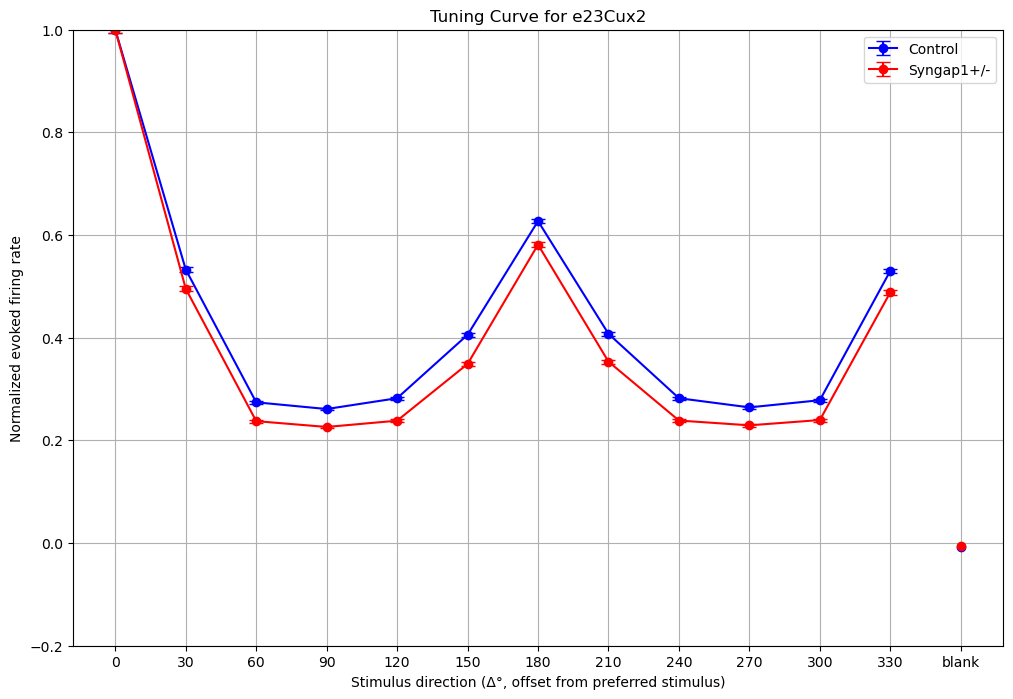

In [33]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 2')

/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


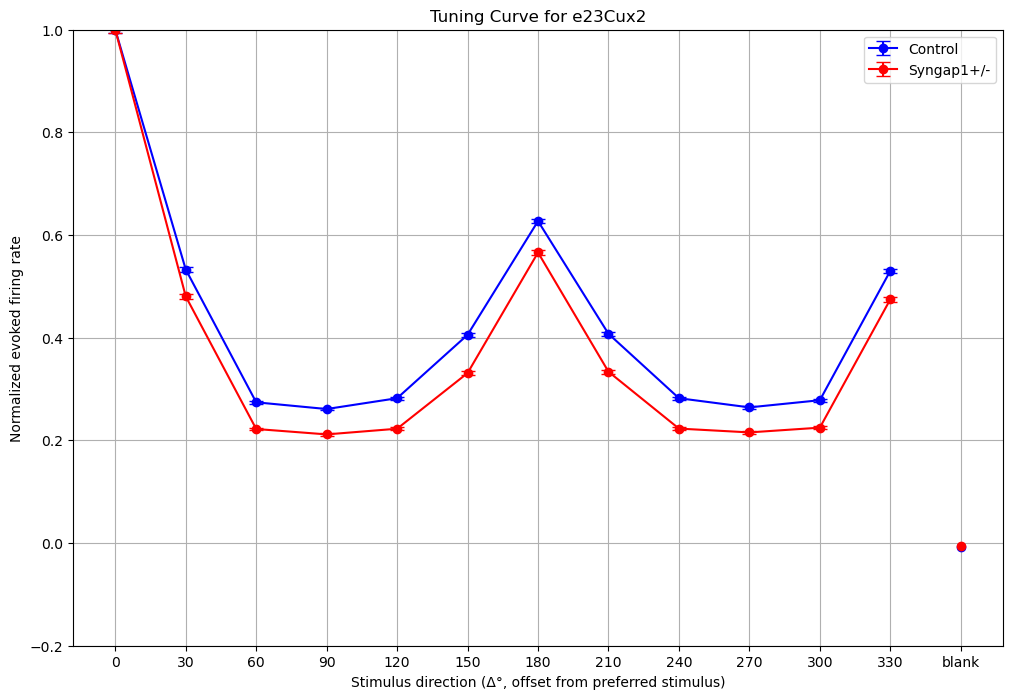

In [34]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 3')

/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2012361351.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


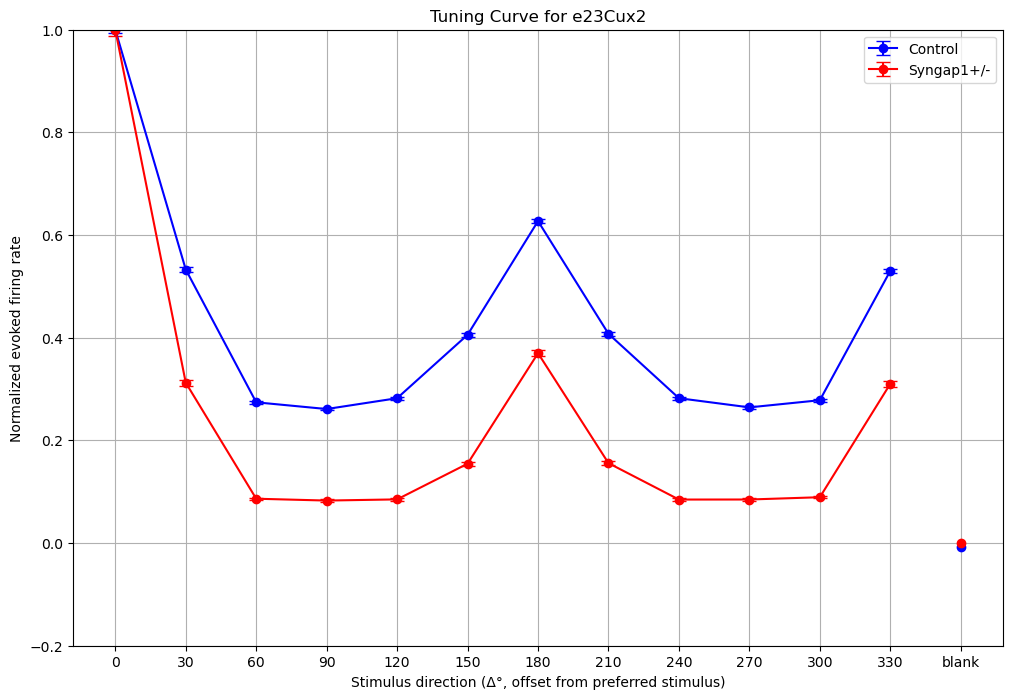

In [35]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 4')

/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


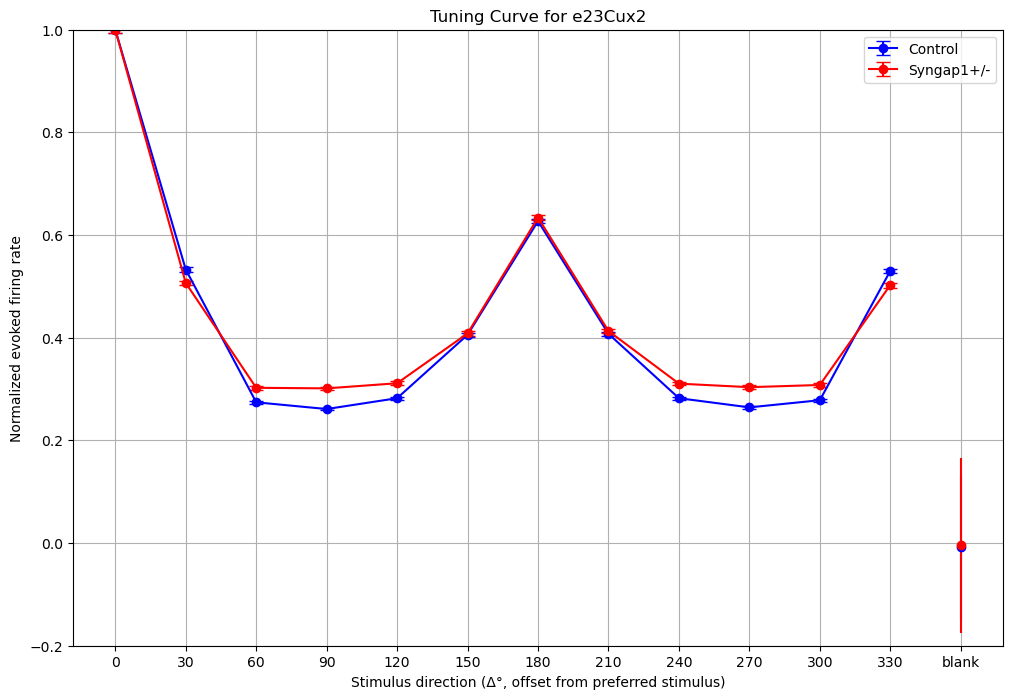

In [9]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 5')

/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


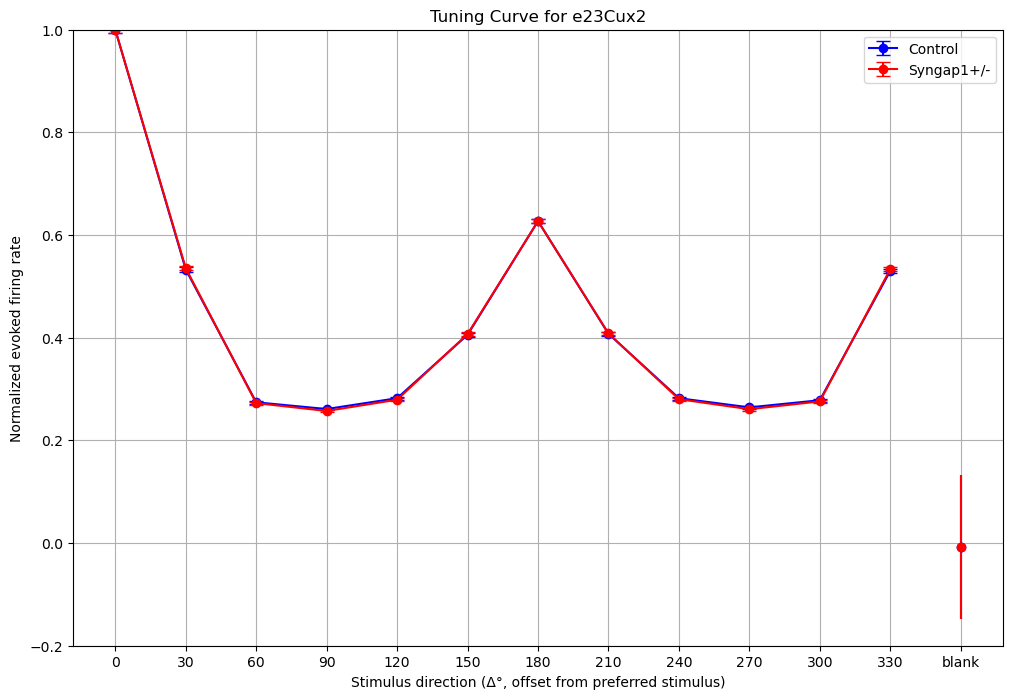

In [10]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 6')

/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


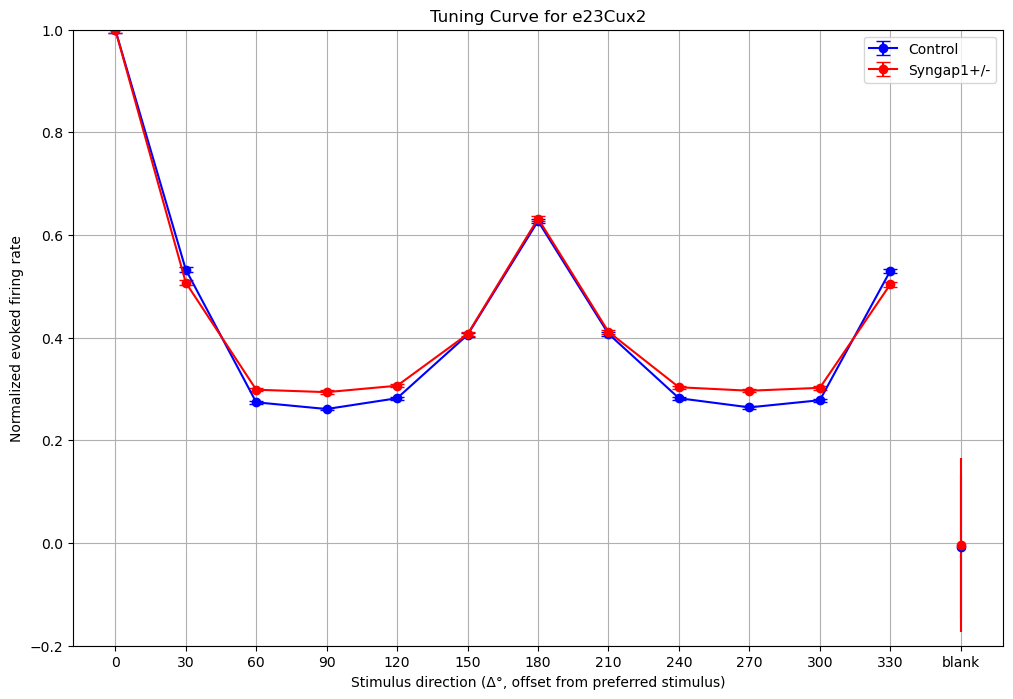

In [11]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 7')

/tmp/ipykernel_31799/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


FileNotFoundError: [Errno 2] No such file or directory: 'syngap simulation 8/Rates_AboveBaseline_DF.csv'

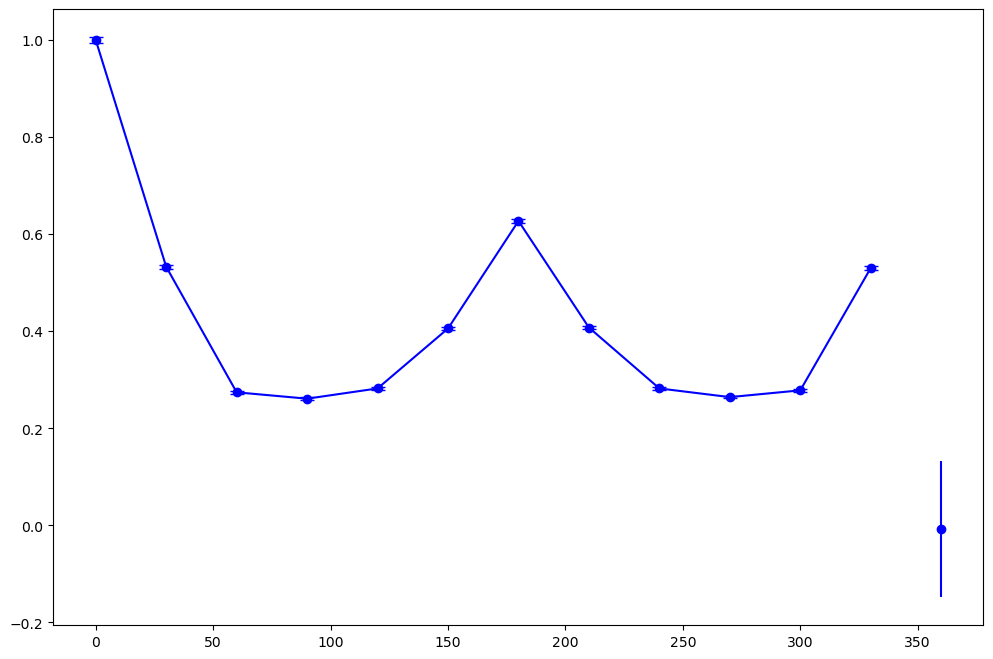

In [28]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 8')

/tmp/ipykernel_31799/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/2920598916.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/2920598916.py:52: RuntimeWarning: divide by zero encountered in scala

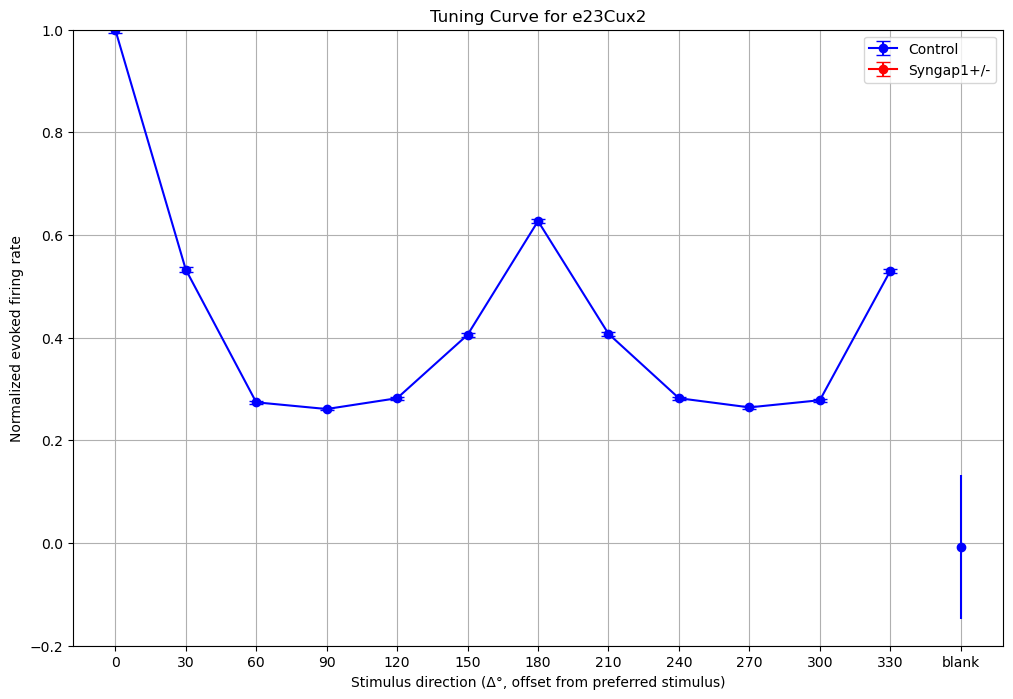

In [29]:
plot_average_normalized_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 10')

In [27]:
# Absolute tuning curve plot for a population
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_absolute_tuning_curves(pop_name, ctrl_folder, exp_folder):
    # Read and filter the v1_nodes.csv
    nodes_df = pd.read_csv('v1_nodes.csv', sep=' ')
    selected_nodes = nodes_df[nodes_df['pop_name'] == pop_name]

    # Define file paths for both conditions with appropriate labels
    orientation_paths = {
        ctrl_folder + '/Rates_AboveBaseline_DF.csv': ('blue', 'Control', ctrl_folder + '/Rates_FullGray_AboveBaseline_DF.csv'),
        exp_folder + '/Rates_AboveBaseline_DF.csv': ('red', 'Syngap1+/-',  exp_folder + '/Rates_FullGray_AboveBaseline_DF.csv')
    }

    plt.figure(figsize=(12, 8))

    # Process each condition
    for file_path, (color, label, gray_file_path) in orientation_paths.items():
        # Read rates data for orientations
        rates_df = pd.read_csv(file_path, sep=' ')
        # Read rates data for blank stimuli
        gray_rates_df = pd.read_csv(gray_file_path, sep=' ')

        # Merge to filter only selected neurons using the correct ID column
        merged_df = pd.merge(selected_nodes, rates_df, left_on='id', right_on='node_id')
        gray_merged_df = pd.merge(selected_nodes, gray_rates_df, left_on='id', right_on='node_id')

        # Normalize orientations based on the maximum firing rate
        def normalize_orientations(group):
            max_ori = group['Avg_rate(Hz)'].idxmax()
            preferred_angle = group.loc[max_ori, 'DG_angle']
            group['Normalized_angle'] = (group['DG_angle'] - preferred_angle) % 360
            return group

        normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)

        # Group by normalized orientation and calculate mean and SEM of the rates
        grouped = normalized_df.groupby('Normalized_angle').agg(
            Avg_rate=('Avg_rate(Hz)', 'mean'),
            SEM_rate=('Avg_rate(Hz)', 'sem')
        ).reset_index().sort_values('Normalized_angle')

        # Plot the average tuning curve
        plt.errorbar(grouped['Normalized_angle'], grouped['Avg_rate'], yerr=grouped['SEM_rate'],
                     fmt='o-', color=color, capsize=5, label=label)
        
        # Plot the gray stimulus point
        plt.errorbar([360], gray_merged_df['Avg_rate(Hz)'].mean(), gray_merged_df['Avg_rate(Hz)'].std()/ np.sqrt(len(gray_merged_df['Avg_rate(Hz)'])), fmt='o', color=color)

    plt.title(f'Tuning Curve for {pop_name}')
    plt.xlabel('Stimulus direction (Δ°, offset from preferred stimulus)')
    plt.ylabel('Evoked firing rate (Hz)')
    plt.xticks(list(np.arange(0, 360, 30)) + [360], labels=list(np.arange(0, 360, 30)) + ['blank'])
    plt.grid(True)
    plt.legend()
    plt.show()

/tmp/ipykernel_23213/2114756688.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/2114756688.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


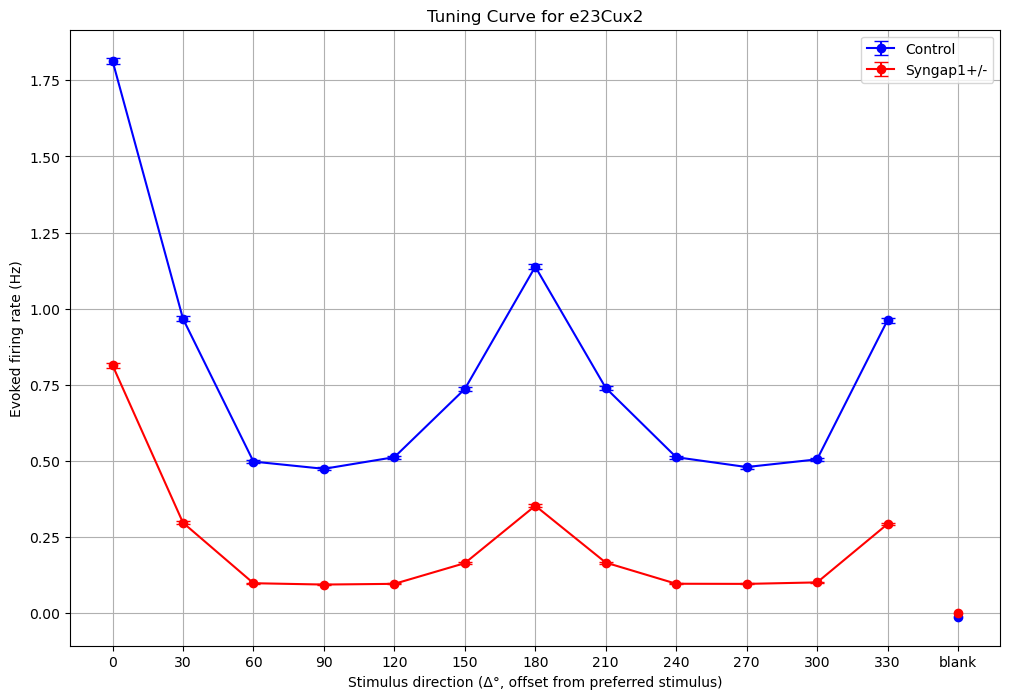

In [28]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 1')

/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


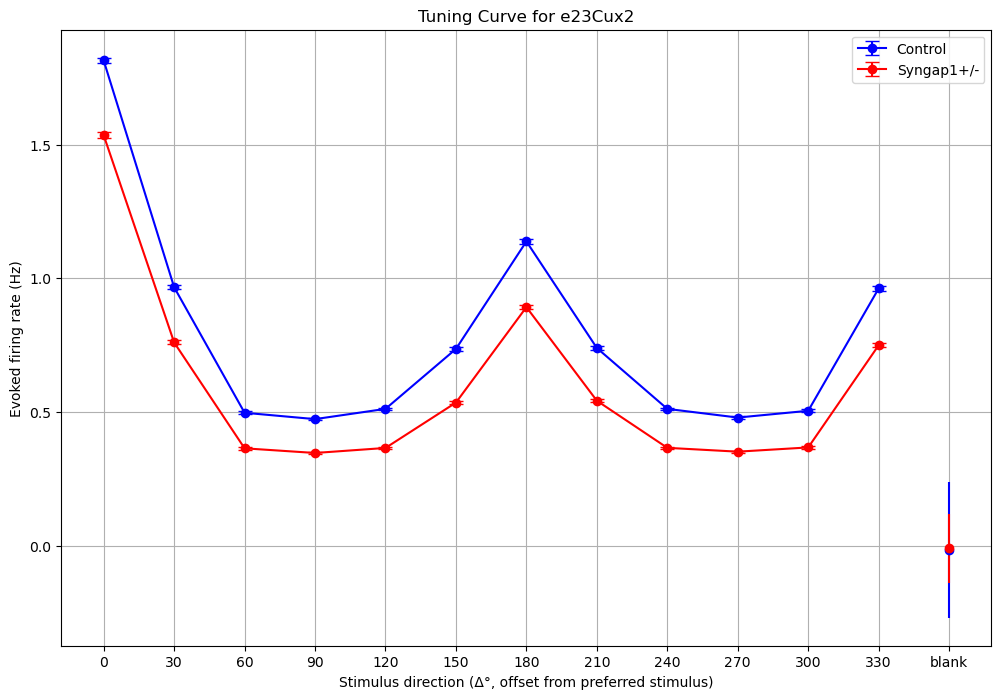

In [12]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 2')

/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


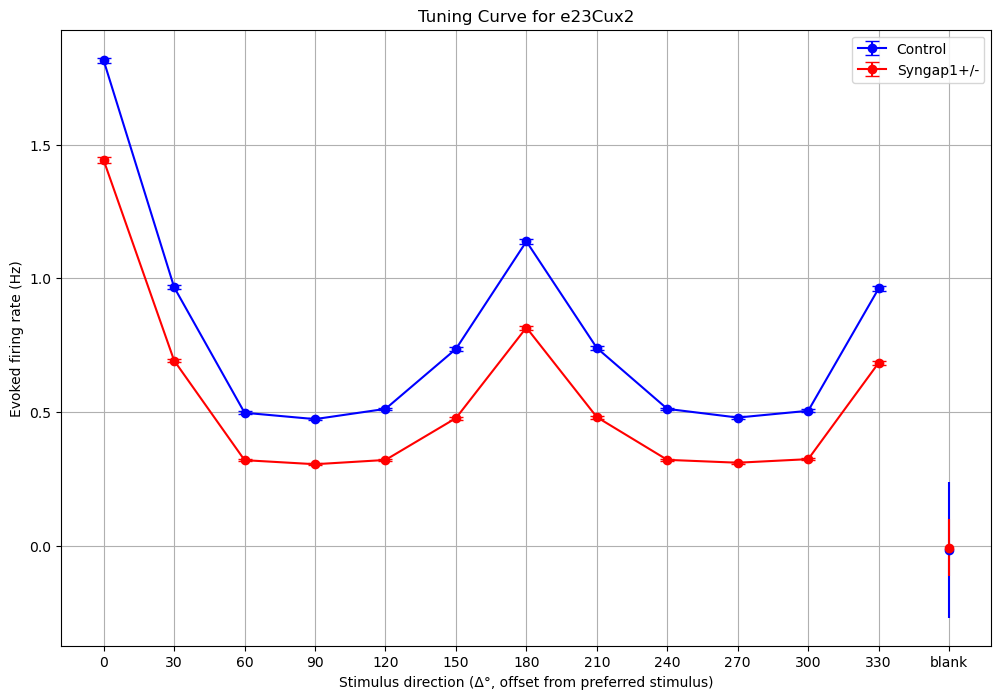

In [13]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 3')

/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


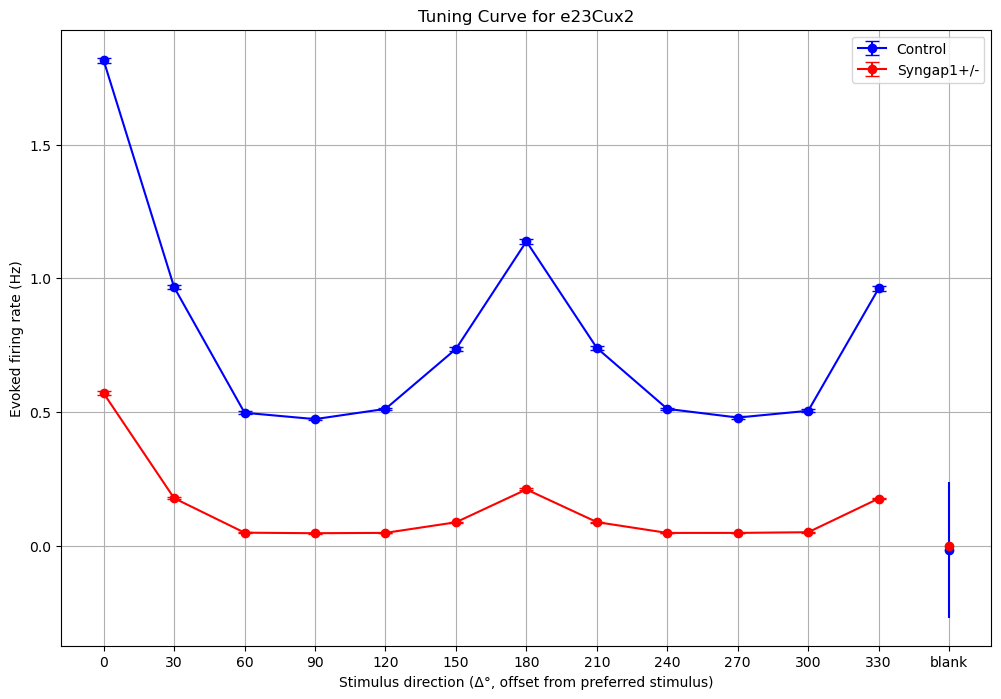

In [14]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 4')

/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


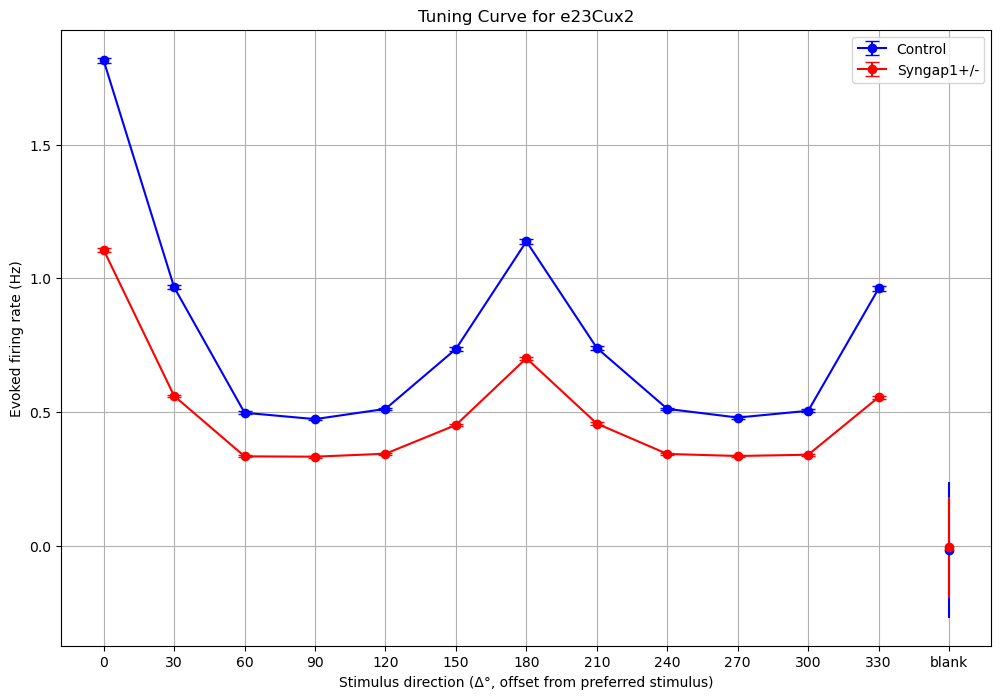

In [4]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 5')

/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


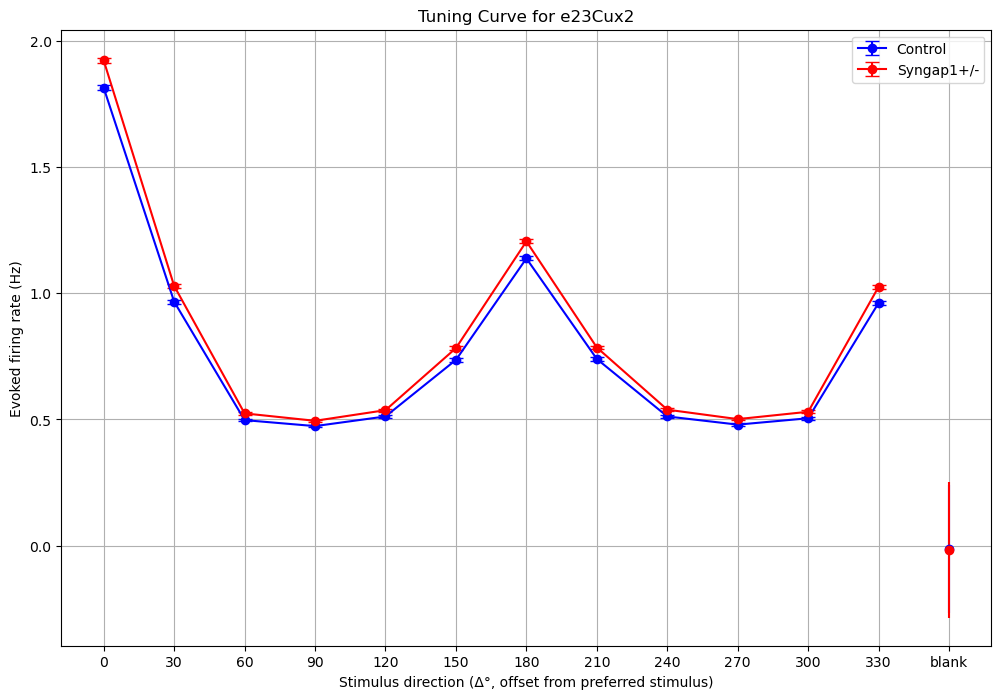

In [5]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 6')

/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_23213/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


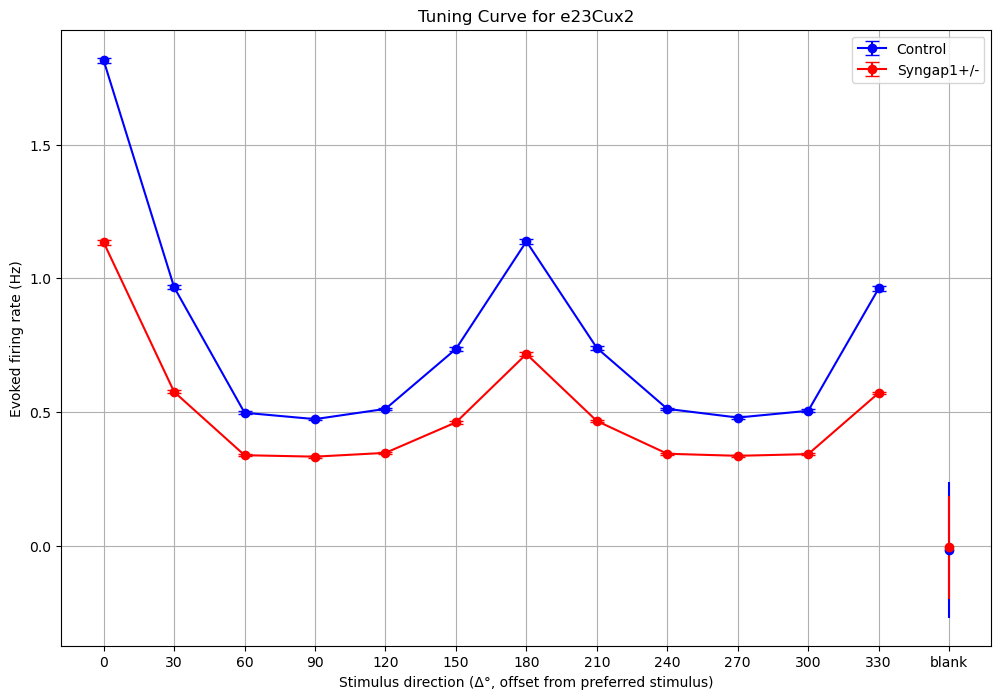

In [6]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 7')

/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)
/tmp/ipykernel_31799/652259462.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = merged_df.groupby('node_id').apply(normalize_orientations)


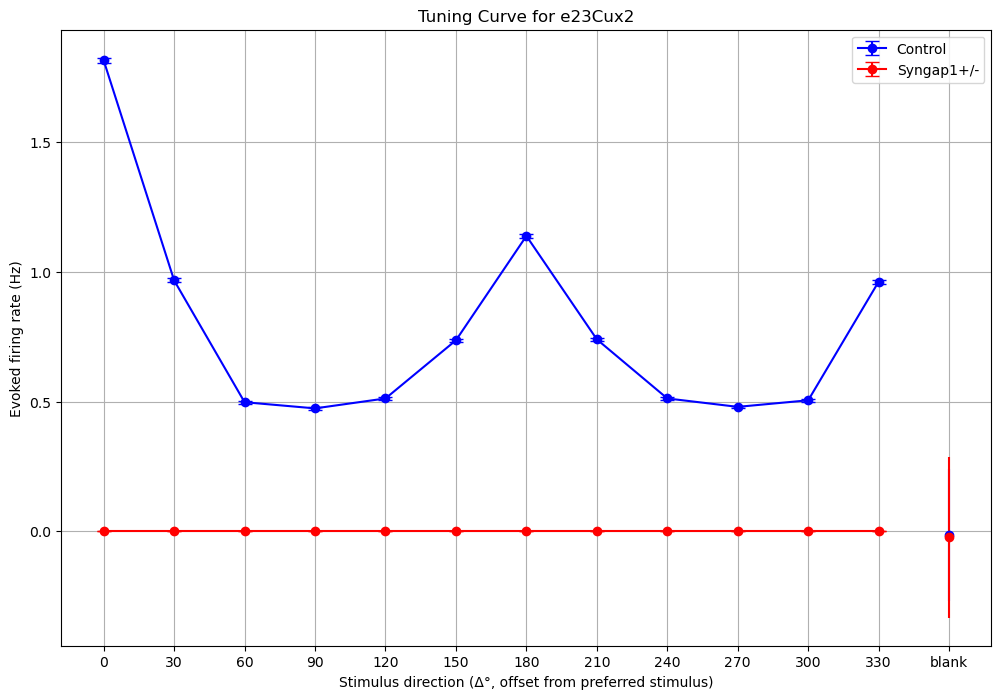

In [30]:
plot_average_absolute_tuning_curves('e23Cux2', 'simulation 2', 'syngap simulation 10')

# 3. Visualize populations with scatterplots

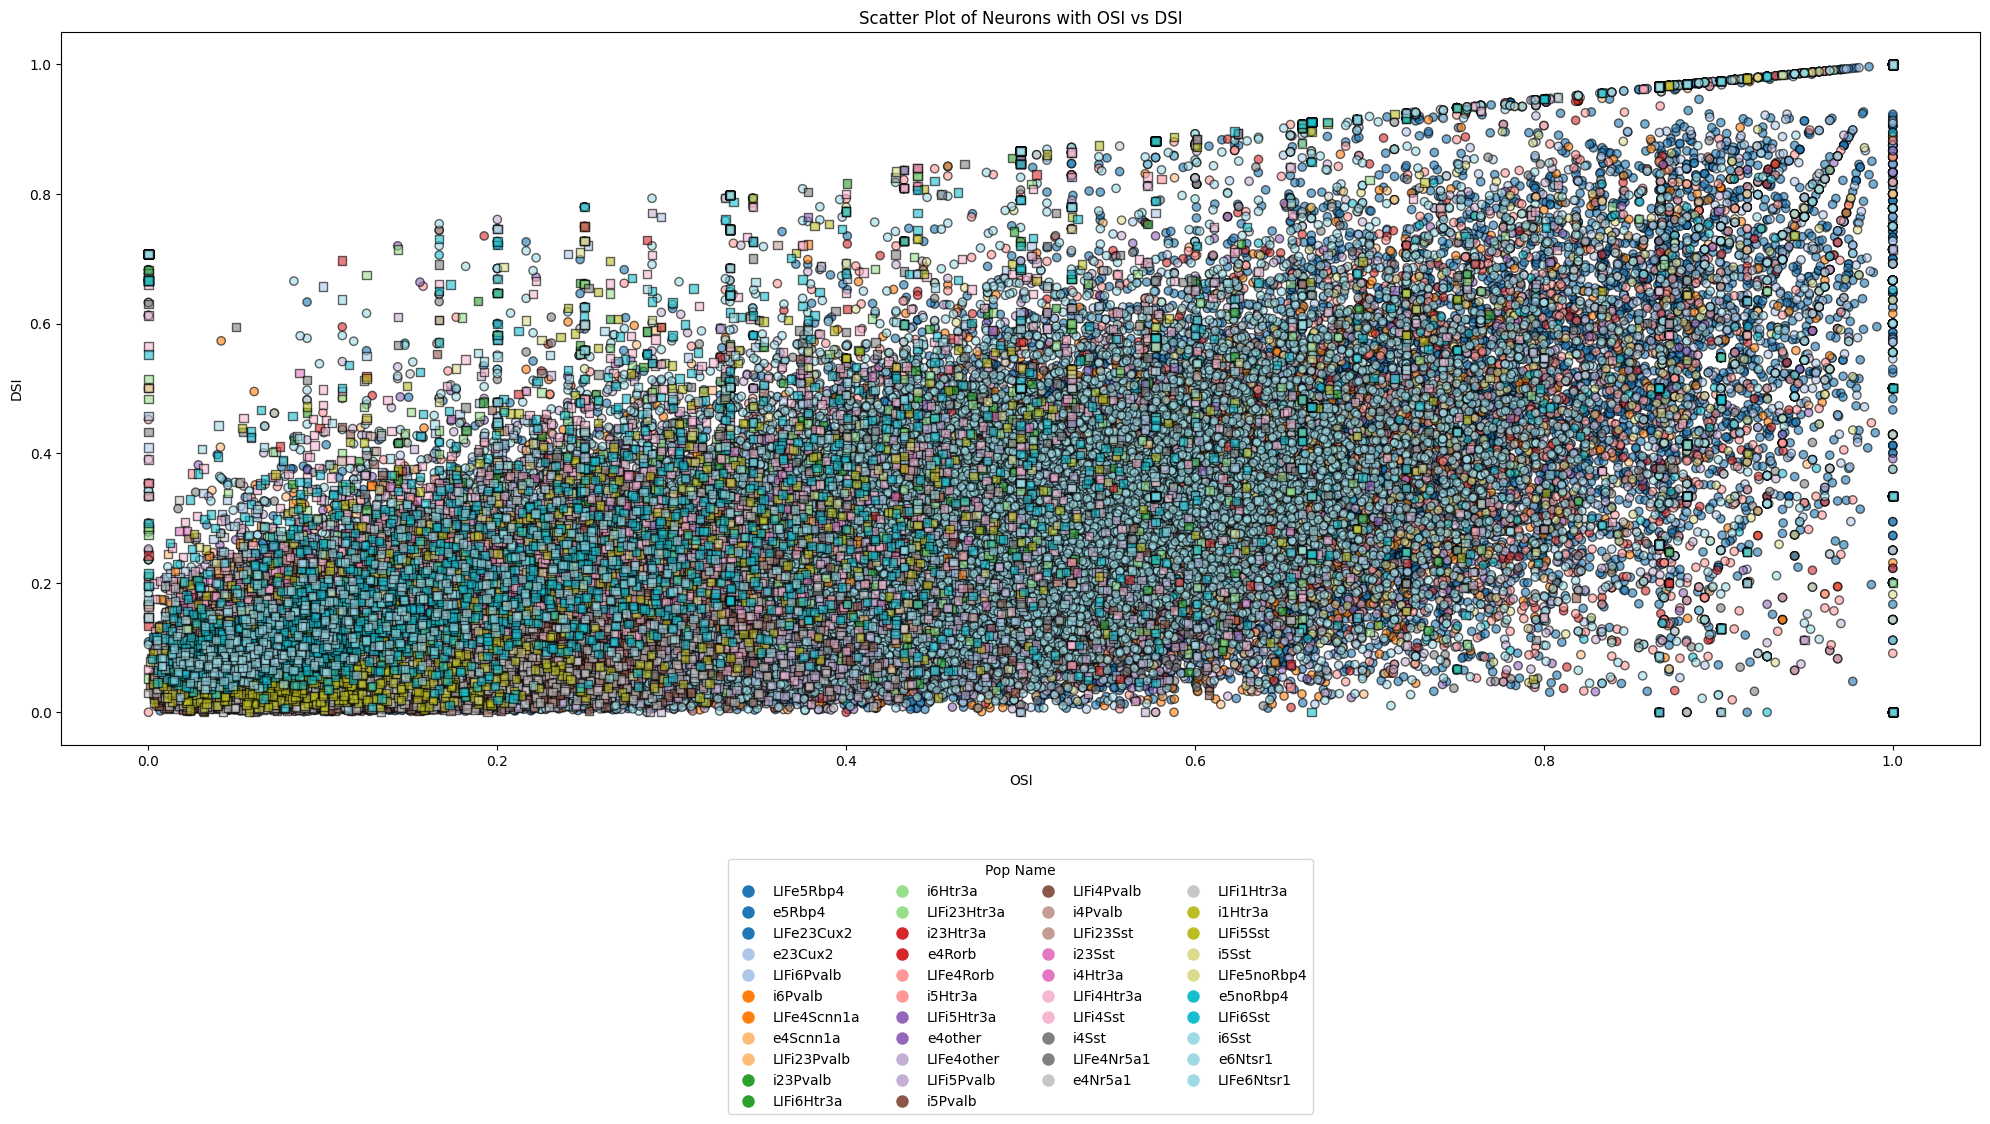

In [170]:
def plot_OSI_DSI_2D():
    # Read the csv files into dataframes
    v1_nodes_df = pd.read_csv('v1_nodes.csv', sep=' ')
    osi_dsi_df = pd.read_csv('simulation 2/OSI_DSI_AboveBaseline_DF.csv', sep=' ')
    
    # Merge the two dataframes on the 'id' and 'node_id' columns respectively
    merged_df = pd.merge(v1_nodes_df, osi_dsi_df, left_on='id', right_on='node_id')
    
    # Filter away neurons whose OSI entry is empty
    filtered_df = merged_df.dropna(subset=['OSI'])
    
    # Plot the scatter plot
    plt.figure(figsize=(20, 10))
    
    # Define colors for each pop_name using the 'tab20' colormap
    pop_names = filtered_df['pop_name'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(pop_names)))
    color_map = dict(zip(pop_names, colors))
    
    # Plot excitatory neurons as round dots
    exc_neurons = filtered_df[filtered_df['ei'] == 'e']
    plt.scatter(exc_neurons['OSI'], exc_neurons['DSI'], 
                c=exc_neurons['pop_name'].map(color_map), 
                label='Excitatory', 
                marker='o', 
                alpha=0.6, 
                edgecolor='k')
    
    # Plot inhibitory neurons as squares
    inh_neurons = filtered_df[filtered_df['ei'] == 'i']
    plt.scatter(inh_neurons['OSI'], inh_neurons['DSI'], 
                c=inh_neurons['pop_name'].map(color_map), 
                label='Inhibitory', 
                marker='s', 
                alpha=0.6, 
                edgecolor='k')
    
    # Add a legend based on pop_name
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[name], markersize=10, label=name) for name in pop_names]
    legend = plt.legend(handles=handles, title='Pop Name', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4)
    
    # Set the axis labels and title
    plt.xlabel('OSI')
    plt.ylabel('DSI')
    plt.title('Scatter Plot of Neurons with OSI vs DSI')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)  # Adjust the bottom to make space for the legend
    
    plt.show()


In [ ]:
plot_OSI_DSI_2D()

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_OSI_DSI_basal_FR_3D(pop_names, ctrl_folder, exp_folder):
    # Read and filter the v1_nodes.csv
    nodes_df = pd.read_csv('v1_nodes.csv', sep=' ')
    selected_nodes = nodes_df[nodes_df['pop_name'].isin(pop_names)]

    # Define file paths for both conditions
    conditions = {
        'control': {
            'osi_dsi_path': ctrl_folder + '/OSI_DSI_AboveBaseline_DF.csv',
            'basal_rates_path': ctrl_folder + '/Basal_Rates_DF.csv',
            'colors': plt.cm.Blues(np.linspace(0.3, 0.9, len(pop_names)))  # Cold colors for control
        },
        'syngap +/-': {
            'osi_dsi_path': exp_folder + '/OSI_DSI_AboveBaseline_DF.csv',
            'basal_rates_path': exp_folder + '/Basal_Rates_DF.csv',
            'colors': plt.cm.Oranges(np.linspace(0.3, 0.9, len(pop_names)))  # Warm colors for syngap +/-
        }
    }

    # Plotting setup
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Process each condition
    for condition, files in conditions.items():
        # Read the CSV files
        osi_dsi_df = pd.read_csv(files['osi_dsi_path'], sep=' ')
        basal_rates_df = pd.read_csv(files['basal_rates_path'], sep=' ')

        # Merge the dataframes
        merged_df = pd.merge(selected_nodes, osi_dsi_df, left_on='id', right_on='node_id')
        merged_df = pd.merge(merged_df, basal_rates_df, on='node_id')

        # Filter away neurons whose OSI entry is empty
        filtered_df = merged_df.dropna(subset=['OSI'])

        # Define colors for each pop_name
        pop_names = filtered_df['pop_name'].unique()
        color_map = dict(zip(pop_names, files['colors']))

        # Scatter plot with different colors by population
        for pop_name in pop_names:
            pop_df = filtered_df[filtered_df['pop_name'] == pop_name]
            ax.scatter(pop_df['OSI'], pop_df['DSI'], pop_df['Avg_rate(Hz)'],
                       c=[color_map[pop_name]], label=f'{condition} {pop_name}',
                       marker='o', alpha=0.6, s=50)

    # Set the axis labels and title
    ax.set_xlabel('OSI')
    ax.set_ylabel('DSI')
    ax.set_zlabel('Basal FR(Hz)')
    ax.set_title('3D Scatter Plot of Neurons with OSI vs DSI vs Basal FR(Hz)')

    # Layout adjustment and legend
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    ax.legend()
    plt.show()

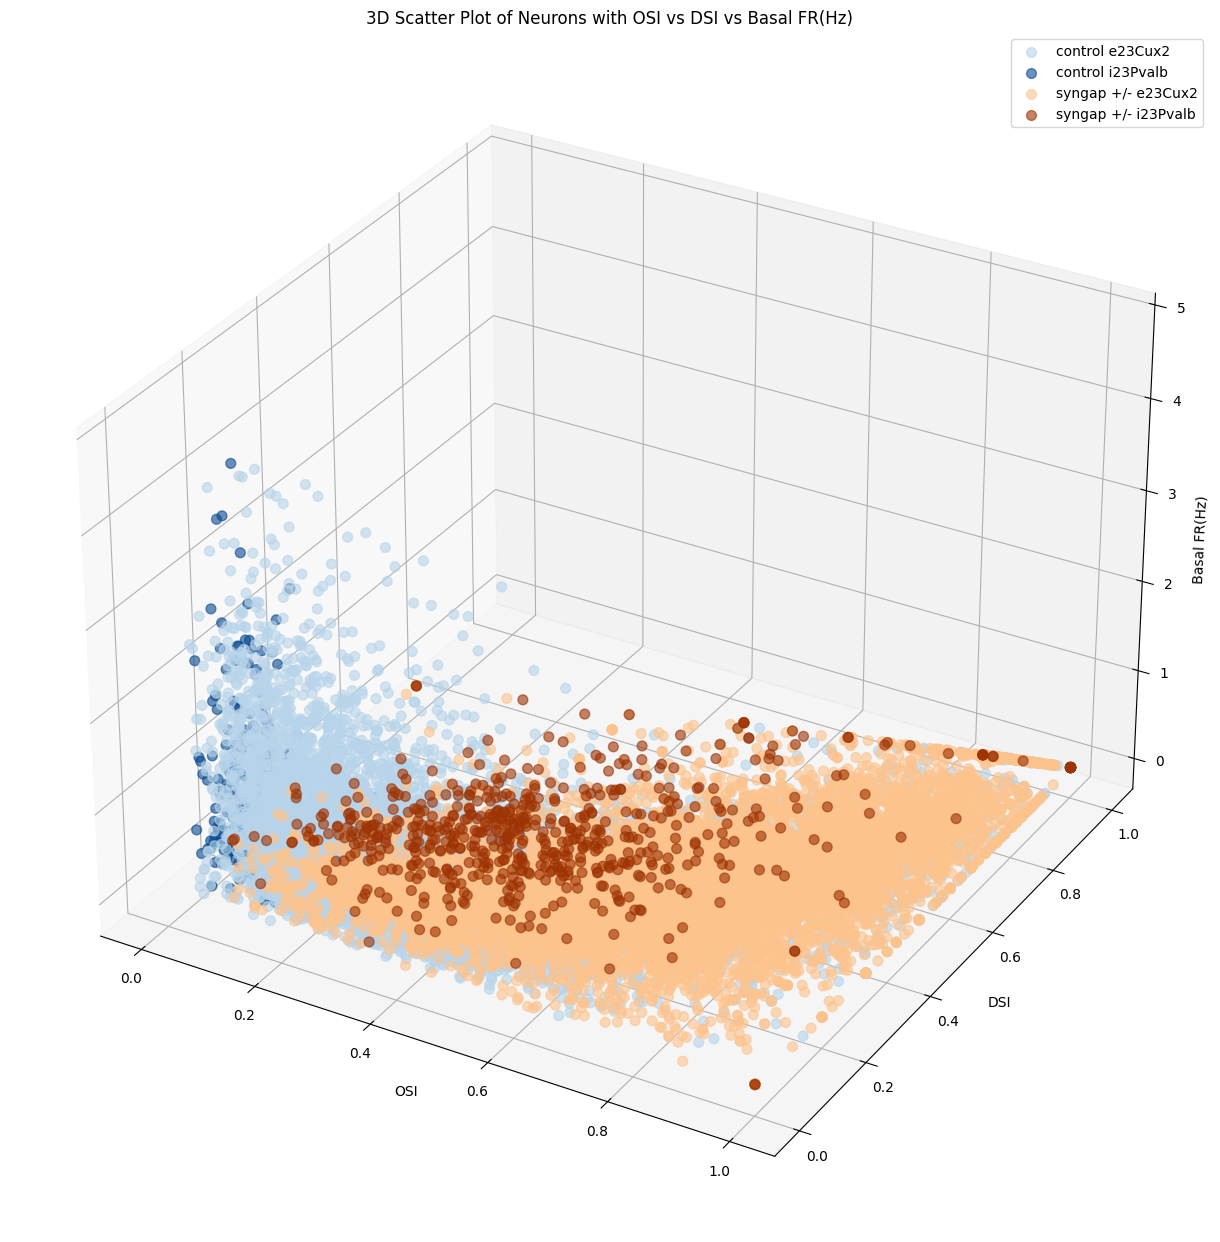

In [175]:
plot_OSI_DSI_basal_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 1')

In [ ]:
plot_OSI_DSI_basal_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 2')

In [ ]:
plot_OSI_DSI_basal_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 3')

In [ ]:
plot_OSI_DSI_basal_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 4')

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_OSI_DSI_FR_3D(pop_names, ctrl_folder, exp_folder):
    # Read and filter the v1_nodes.csv
    nodes_df = pd.read_csv('v1_nodes.csv', sep=' ')
    selected_nodes = nodes_df[nodes_df['pop_name'].isin(pop_names)]

    # Define file paths for both conditions
    conditions = {
        'control': {
            'osi_dsi_path': ctrl_folder + '/OSI_DSI_AboveBaseline_DF.csv',
            'basal_rates_path': ctrl_folder + '/Rates_AboveBaseline_DF.csv',
            'colors': plt.cm.Blues(np.linspace(0.3, 0.9, len(pop_names)))  # Cold colors for control
        },
        'syngap +/-': {
            'osi_dsi_path': exp_folder + '/OSI_DSI_AboveBaseline_DF.csv',
            'basal_rates_path': exp_folder + '/Rates_AboveBaseline_DF.csv',
            'colors': plt.cm.Oranges(np.linspace(0.3, 0.9, len(pop_names)))  # Warm colors for syngap +/-
        }
    }

    # Plotting setup
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    # Process each condition
    for condition, files in conditions.items():
        # Read the CSV files
        osi_dsi_df = pd.read_csv(files['osi_dsi_path'], sep=' ')
        basal_rates_df = pd.read_csv(files['basal_rates_path'], sep=' ')

        # Merge the dataframes
        merged_df = pd.merge(selected_nodes, osi_dsi_df, left_on='id', right_on='node_id')
        merged_df = pd.merge(merged_df, basal_rates_df, on='node_id')

        # Filter away neurons whose OSI entry is empty
        filtered_df = merged_df.dropna(subset=['OSI'])

        # Define colors for each pop_name
        pop_names = filtered_df['pop_name'].unique()
        color_map = dict(zip(pop_names, files['colors']))

        # Scatter plot with different colors by population
        for pop_name in pop_names:
            pop_df = filtered_df[filtered_df['pop_name'] == pop_name]
            ax.scatter(pop_df['OSI'], pop_df['DSI'], pop_df['Avg_rate(Hz)'],
                       c=[color_map[pop_name]], label=f'{condition} {pop_name}',
                       marker='o', alpha=0.6, s=50)

    # Set the axis labels and title
    ax.set_xlabel('OSI')
    ax.set_ylabel('DSI')
    ax.set_zlabel('Basal FR(Hz)')
    ax.set_title('3D Scatter Plot of Neurons with OSI vs DSI vs Basal FR(Hz)')

    # Layout adjustment and legend
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    ax.legend()
    plt.show()

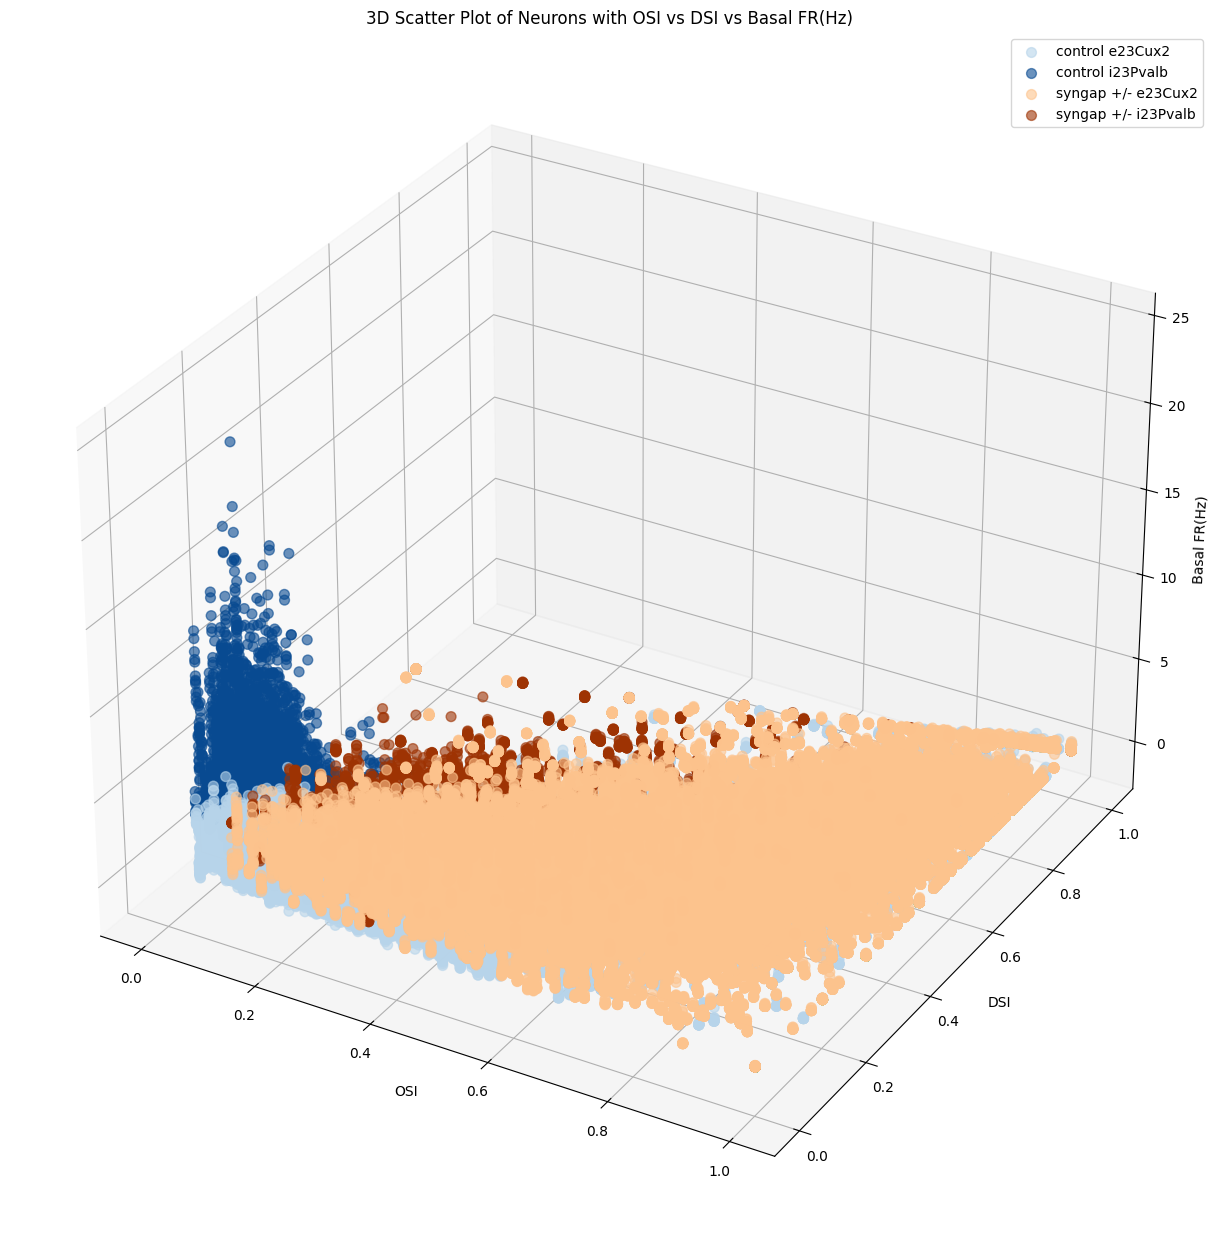

In [178]:
plot_OSI_DSI_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 1')

In [ ]:
plot_OSI_DSI_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 2')

In [ ]:
plot_OSI_DSI_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 3')

In [ ]:
plot_OSI_DSI_FR_3D(['e23Cux2', 'i23Pvalb'], 'simulation 2', 'syngap simulation 4')